# Taller - HMM, Cópulas y Stress Testing (2006-hoy)

Notebook técnico para modelar cambios de régimen, dependencia y riesgo de cola en una cartera multi-activo long-only.

Universo de activos: AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM, GLD, IEF, SHY, HYG.

Rango temporal objetivo: desde 2006-01-01 hasta fecha disponible.

## Ejecución y reproducibilidad

Objetivo técnico: que el notebook corra de principio a fin en cualquier equipo sin rutas absolutas.

- El directorio de proyecto se detecta automáticamente.
- Los datos se descargan desde Yahoo Finance solo si no hay cache local.
- Se guardan CSV en `outputs_taller/` para acelerar ejecuciones futuras.
- Se fija semilla en simulaciones para reproducibilidad.

Nota de proxies (bonos/crédito):

- 10Y UST -> `IEF`
- 2Y UST -> `SHY`
- High Yield -> `HYG`

Estos proxies se usan para mantener frecuencia diaria uniforme y evitar incompatibilidades de fuentes heterogéneas.

In [1]:
# Importaciones necesarias para el análisis de riesgos financieros
from __future__ import annotations  # Permite usar anotaciones de tipo futuras

# Librerías estándar de Python
import os
from pathlib import Path

# Librerías científicas y de análisis de datos
import numpy as np
import pandas as pd
import yfinance as yf  # Para descargar datos financieros de Yahoo Finance

# Control de advertencias durante la ejecución
import warnings

# Machine Learning - Modelos Hidden Markov
from hmmlearn.hmm import GaussianHMM  # Modelo HMM con distribuciones gaussianas
from sklearn.preprocessing import StandardScaler  # Para estandarizar características

# Funciones matemáticas y estadísticas
from scipy.special import logsumexp  # Para cálculo estable de log-sum-exp

# Visualización de datos
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Manejo de datos JSON y distribuciones estadísticas
import json
from scipy.stats import norm, t  # Distribuciones normal y t-Student


def find_project_root(
    start_dir: Path,
    markers: tuple[str, ...],
    max_depth: int = 8,
 ) -> Path | None:
    """Encuentra el directorio raíz del proyecto de forma automática.

    Evitamos codificar rutas absolutas. La raíz es el primer directorio que
    contiene cualquiera de los archivos/marcadores especificados.
    """
    current = start_dir.resolve()
    for _ in range(max_depth + 1):
        for marker in markers:
            if (current / marker).exists():
                return current
        if current.parent == current:
            break
        current = current.parent
    return None


# --- Configuración de rutas (portable) ---
# Marcadores que identifican el directorio raíz del proyecto
MARKERS = (
    "Taller_Riesgos_HMM_Copulasv2_main.ipynb",
    "Taller_Riesgos_HMM_Copulasv2.pdf",
    "Taller_Riesgos_HMM_Copulasv2_analisis.md",
 )

# Override opcional (útil si se lanza Jupyter desde una carpeta diferente)
# Ejemplo: set TALLER_DIR="C:\\...\\tema 6 Gestion de riesgos"
override = os.environ.get("TALLER_DIR")
if override:
    PROJECT_DIR = Path(override).expanduser().resolve()
else:
    PROJECT_DIR = find_project_root(Path.cwd(), MARKERS) or Path.cwd().resolve()

# Directorio de salida para resultados y datos cacheados
OUT_DIR = PROJECT_DIR / "outputs_taller"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Rutas de archivos CSV para datos cacheados
PRICES_CSV = OUT_DIR / "prices_adj_close.csv"  # Precios ajustados
RETURNS_CSV = OUT_DIR / "returns_log.csv"      # Retornos logarítmicos

# --- Universo de activos solicitado (acciones + bonos + HY + oro) ---
# Tickers de acciones estadounidenses
EQUITY_TICKERS = [
    "AAPL",   # Apple Inc.
    "AMZN",   # Amazon.com Inc.
    "BAC",    # Bank of America Corp.
    "BRK-B",  # Berkshire Hathaway Inc. Class B
    "CVX",    # Chevron Corp.
    "ENPH",   # Enphase Energy Inc.
    "GME",    # GameStop Corp.
    "GOOGL",  # Alphabet Inc. Class A
    "JNJ",    # Johnson & Johnson
    "JPM",    # JPMorgan Chase & Co.
    "MSFT",   # Microsoft Corp.
    "NVDA",   # NVIDIA Corp.
    "PG",     # Procter & Gamble Co.
    "XOM",    # Exxon Mobil Corp.
]

# Tickers de activos defensivos y de deuda
GOLD_TICKER = "GLD"        # SPDR Gold Shares (ETF de oro)
BOND_10Y_TICKER = "IEF"    # iShares 7-10 Year Treasury Bond ETF (proxy bonos 7-10a)
BOND_2Y_TICKER = "SHY"     # iShares 1-3 Year Treasury Bond ETF (proxy bonos 1-3a)
HY_TICKER = "HYG"          # iShares iBoxx $ High Yield Corporate Bond ETF (high yield)

# Lista completa de todos los tickers a analizar
TICKERS = EQUITY_TICKERS + [GOLD_TICKER, BOND_10Y_TICKER, BOND_2Y_TICKER, HY_TICKER]

# Fechas de análisis
START = "2006-01-01"  # Fecha de inicio del análisis
END = None           # None => hasta la fecha actual (hoy)

## 0) Descarga y preparación de datos

Trabajamos con `Adj Close` para construir retornos logarítmicos diarios.

Se construyen tres paneles de trabajo (CORE, FULL y diagnostico 2006) y el flujo principal usa CORE para preservar el episodio de 2008 sin imputar precios faltantes.

In [2]:
def download_prices(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """Descarga precios históricos desde Yahoo Finance.
    
    Args:
        tickers: Lista de símbolos de activos a descargar
        start: Fecha de inicio (formato YYYY-MM-DD)
        end: Fecha de fin (formato YYYY-MM-DD) o None para hoy
        
    Returns:
        DataFrame con precios de cierre ajustados por activo
    """
    # Descarga datos usando yfinance
    data = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=False,      # Mantener columnas originales (Adj Close, Close, etc.)
        progress=False,         # No mostrar barra de progreso
        group_by="column",       # Agrupar por ticker (más fácil de procesar)
    )
    
    # yfinance devuelve columnas MultiIndex cuando hay varios tickers
    if isinstance(data.columns, pd.MultiIndex):
        # Preferimos precios de cierre ajustados (Adj Close) que incluyen dividendos y splits
        if "Adj Close" in data.columns.get_level_values(0):
            prices = data["Adj Close"].copy()
        else:
            # Fallback a Close si no hay Adj Close disponible
            prices = data["Close"].copy()
    else:
        # Caso especial: solo un ticker (estructura diferente)
        prices = data[["Adj Close"]].rename(columns={"Adj Close": tickers[0]})

    # Asegurar formato correcto de fechas y orden cronológico
    prices.index = pd.to_datetime(prices.index)
    prices = prices.sort_index()
    return prices


def _normalize_cached_prices(df: pd.DataFrame) -> pd.DataFrame:
    """Normaliza DataFrame cargado desde cache CSV.
    
    Limpia y estandariza el formato de datos cargados desde archivo.
    
    Args:
        df: DataFrame cargado desde CSV
        
    Returns:
        DataFrame normalizado con fechas y columnas limpias
    """
    # Algunos CSV pueden incluir columnas sin nombre; asegurar columnas/índice limpios
    df = df.copy()
    df.index = pd.to_datetime(df.index)      # Convertir índice a datetime
    df = df.sort_index()                     # Ordenar por fecha cronológica
    df.columns = [str(c).strip() for c in df.columns]  # Limpiar nombres de columnas
    return df


def load_or_download_prices(
    tickers: list[str],
    start: str,
    end: str,
    cache_path: Path,
 ) -> pd.DataFrame:
    """Carga precios desde cache o descarga si es necesario.
    
    Implementa sistema de cache para evitar descargas repetidas
    y acelerar ejecuciones posteriores.
    
    Args:
        tickers: Lista de símbolos de activos
        start: Fecha de inicio
        end: Fecha de fin
        cache_path: Ruta del archivo cache
        
    Returns:
        DataFrame con precios de los tickers solicitados
    """
    tickers_set = set(tickers)
    
    # Verificar si existe cache válido
    if cache_path.exists():
        # Cargar datos cacheados y normalizar formato
        cached = _normalize_cached_prices(pd.read_csv(cache_path, index_col=0, parse_dates=True))
        cached_cols = set(cached.columns)
        
        # Si el cache contiene al menos los tickers necesarios, reutilizarlo (subset)
        if tickers_set.issubset(cached_cols):
            print(f"✓ Cargando {len(tickers)} tickers desde cache: {cache_path.name}")
            return cached.loc[:, tickers]
        # Si no, refrescar cache para el universo exacto solicitado
        
    # Descargar datos frescos si no hay cache o está incompleto
    print(f"⬇ Descargando {len(tickers)} tickers desde Yahoo Finance...")
    prices = download_prices(tickers, start, end)
    
    # Guardar en cache para futuras ejecuciones
    prices.to_csv(cache_path, encoding="utf-8")
    print(f" Cache guardado en: {cache_path}")
    
    return prices


# Ejecutar carga/descarga de precios para el universo completo
prices = load_or_download_prices(TICKERS, START, END, PRICES_CSV)

# Mostrar últimos precios y dimensiones del dataset
print(f"\n Dataset de precios:")
print(f"   - Período: {prices.index.min().date()} → {prices.index.max().date()}")
print(f"   - Activos: {prices.shape[1]}")
print(f"   - Días de trading: {prices.shape[0]:,}")

# Mostrar últimas filas y forma del DataFrame
prices.tail(), prices.shape

✓ Cargando 18 tickers desde cache: prices_adj_close.csv

 Dataset de precios:
   - Período: 2006-01-03 → 2026-02-13
   - Activos: 18
   - Días de trading: 5,061


(                  AAPL        AMZN        BAC       BRK-B         CVX  \
 Date                                                                    
 2026-02-09  274.619995  208.720001  56.410000  498.079987  182.600006   
 2026-02-10  273.679993  206.960007  55.389999  500.299988  182.259995   
 2026-02-11  275.500000  204.080002  53.849998  500.019989  185.820007   
 2026-02-12  261.730011  199.600006  52.520000  500.010010  182.399994   
 2026-02-13  255.779999  198.789993  52.549999  497.549988  183.740005   
 
                  ENPH        GME       GOOGL         JNJ         JPM  \
 Date                                                                   
 2026-02-09  50.299999  24.639999  324.320007  238.639999  322.100006   
 2026-02-10  50.250000  24.820000  318.579987  238.350006  318.279999   
 2026-02-11  48.230000  24.209999  310.959991  240.860001  310.820007   
 2026-02-12  44.139999  23.520000  309.000000  244.550003  302.640015   
 2026-02-13  43.490002  23.570000  305.720

In [3]:
# Construcción de paneles temporales
# ---------------------------------
# Panel CORE:
#   - Incluye solo tickers con histórico previo al shock de 2008.
#   - Se usa para HMM, copulas, simulación y escenarios.
# Panel FULL:
#   - Mantiene el universo completo para chequeos de robustez.
# Panel 2006:
#   - Sirve como diagnóstico de cobertura desde 2006.
#
# En el resto del notebook, `common`, `prices` y `returns` se refieren al panel CORE.

# Guardar copia del universo completo descargado
prices_full = prices.copy()  # descargado (universo completo)

# Determinar primera fecha disponible por ticker (para decidir composición de paneles)
first_date = prices_full.apply(lambda s: s.first_valid_index()).dropna()
first_date = first_date.sort_values()

# Preservar listas originales del universo declarado
TICKERS_FULL = list(TICKERS)
EQUITY_TICKERS_FULL = list(EQUITY_TICKERS)

# --- Definición de criterios temporales para paneles ---
CORE_CUTOFF = pd.Timestamp("2008-09-01")      # Antes del shock de Lehman (aprox.)
LONG2006_CUTOFF = pd.Timestamp("2006-01-03")  # Primeros días de trading de 2006

# Panel CORE: tickers con datos disponibles antes de la crisis de 2008
# Incluye HYG porque empezó en 2007, antes del colapso de Lehman
TICKERS_CORE = [t for t in TICKERS_FULL if (t in first_date.index and first_date.loc[t] <= CORE_CUTOFF)]

# Panel 2006: tickers con datos desde principios de 2006
# No necesariamente incluye HYG (que empezó más tarde)
TICKERS_2006 = [t for t in TICKERS_FULL if (t in first_date.index and first_date.loc[t] <= LONG2006_CUTOFF)]


def build_panel(px: pd.DataFrame, tickers: list[str], start: str | None = None, end: str | None = None):
    """Construye panel temporal con precios y retornos logarítmicos.
    
    Args:
        px: DataFrame de precios completos
        tickers: Lista de tickers a incluir en el panel
        start: Fecha de inicio (opcional)
        end: Fecha de fin (opcional)
        
    Returns:
        tuple: (precios_comunes, retornos_logaritmicos)
    """
    # Seleccionar tickers específicos del universo completo
    p = px.loc[:, tickers].copy()
    
    # Aplicar filtros temporales si se especifican
    if start is not None:
        p = p.loc[pd.to_datetime(start):]
    if end is not None:
        p = p.loc[:pd.to_datetime(end)]
    
    # Eliminar días con datos faltantes (requiere datos completos para todos los tickers)
    common = p.dropna(how="any")
    
    # Calcular retornos logarítmicos: r_t = log(P_t / P_{t-1})
    returns = np.log(common / common.shift(1)).dropna()
    
    return common, returns


# Construir los tres paneles temporales
print(" Construyendo paneles temporales...")
common_core, returns_core = build_panel(prices_full, TICKERS_CORE, start=START, end=END)
common_full, returns_full = build_panel(prices_full, TICKERS_FULL, start=START, end=END)
common_2006, returns_2006 = build_panel(prices_full, TICKERS_2006, start=START, end=END)


def _panel_summary(name: str, tickers: list[str], common: pd.DataFrame, returns: pd.DataFrame):
    """Muestra resumen estadístico de un panel temporal.
    
    Args:
        name: Nombre descriptivo del panel
        tickers: Lista de tickers en el panel
        common: DataFrame de precios comunes
        returns: DataFrame de retornos
    """
    if len(tickers) == 0:
        print(f"\n[{name}] (vacío)")
        return
    
    # Identificar el ticker que limita el rango temporal (el que empieza más tarde)
    limiter = first_date.loc[tickers].idxmax()
    limiter_date = first_date.loc[tickers].max()
    
    print(f"\n[{name}]")
    print(f" tickers: {len(tickers)}")
    print(f" range (prices):  {common.index.min().date()} -> {common.index.max().date()}  rows: {len(common):,}")
    print(f" range (returns): {returns.index.min().date()} -> {returns.index.max().date()}  rows: {len(returns):,}")
    print(f" limiting ticker (último en arrancar): {limiter}  first_date={limiter_date.date()}")


# Mostrar resúmenes de los tres paneles
_panel_summary("CORE (<=2008)", TICKERS_CORE, common_core, returns_core)
_panel_summary("FULL (universo completo)", TICKERS_FULL, common_full, returns_full)
_panel_summary("2006 (diagnóstico)", TICKERS_2006, common_2006, returns_2006)

# Identificar y mostrar tickers excluidos del panel CORE
excluded = sorted(set(TICKERS_FULL) - set(TICKERS_CORE))
if excluded:
    print("\n Tickers EXCLUIDOS del CORE (no existían antes de 2008 o no tienen histórico suficiente):")
    print(excluded)

# --- Selección del panel principal para el resto del análisis (CORE) ---
# A partir de aquí, todas las variables principales se refieren al panel CORE
common = common_core
prices = common_core
returns = returns_core

# Actualizar listas de tickers para evitar errores en celdas posteriores
TICKERS = list(common.columns)
EQUITY_TICKERS = [t for t in EQUITY_TICKERS_FULL if t in TICKERS]

print(f"\n Panel principal seleccionado: CORE con {len(TICKERS)} activos")
print(f" Período de análisis: {returns.index.min().date()} → {returns.index.max().date()}")

# Sistema de cache para retornos del panel CORE
rebuild_returns_cache = True
if RETURNS_CSV.exists():
    try:
        cached_r = pd.read_csv(RETURNS_CSV, index_col=0, parse_dates=True)
        cached_cols = [str(c).strip() for c in cached_r.columns]
        rebuild_returns_cache = set(cached_cols) != set(returns.columns)
    except Exception:
        rebuild_returns_cache = True

if rebuild_returns_cache:
    print(f" Guardando cache de retornos CORE en: {RETURNS_CSV.name}")
    returns.to_csv(RETURNS_CSV, encoding="utf-8")
else:
    print(f"✓ Reutilizando cache de retornos CORE: {RETURNS_CSV.name}")

# Cache opcional del universo completo para análisis de robustez
RETURNS_FULL_CSV = OUT_DIR / "returns_log_full_universe.csv"
if not RETURNS_FULL_CSV.exists():
    print(f" Guardando cache de retornos FULL en: {RETURNS_FULL_CSV.name}")
    returns_full.to_csv(RETURNS_FULL_CSV, encoding="utf-8")

# Estadísticas descriptivas de los retornos del panel principal
print(f"\n Estadísticas descriptivas - Retornos diarios del panel CORE:")
returns.describe().T[["mean", "std", "min", "max"]]

 Construyendo paneles temporales...

[CORE (<=2008)]
 tickers: 17
 range (prices):  2007-04-11 -> 2026-02-13  rows: 4,743
 range (returns): 2007-04-12 -> 2026-02-13  rows: 4,742
 limiting ticker (último en arrancar): HYG  first_date=2007-04-11

[FULL (universo completo)]
 tickers: 18
 range (prices):  2012-03-30 -> 2026-02-13  rows: 3,489
 range (returns): 2012-04-02 -> 2026-02-13  rows: 3,488
 limiting ticker (último en arrancar): ENPH  first_date=2012-03-30

[2006 (diagnóstico)]
 tickers: 16
 range (prices):  2006-01-03 -> 2026-02-13  rows: 5,061
 range (returns): 2006-01-04 -> 2026-02-13  rows: 5,060
 limiting ticker (último en arrancar): AAPL  first_date=2006-01-03

 Tickers EXCLUIDOS del CORE (no existían antes de 2008 o no tienen histórico suficiente):
['ENPH']

 Panel principal seleccionado: CORE con 17 activos
 Período de análisis: 2007-04-12 → 2026-02-13
✓ Reutilizando cache de retornos CORE: returns_log.csv

 Estadísticas descriptivas - Retornos diarios del panel CORE:


,mean,std,min,max
AAPL,0.000954,0.019768,-0.197470,0.142617
AMZN,0.000961,0.023592,-0.151398,0.238621
BAC,0.000088,0.030171,-0.342058,0.302096
BRK-B,0.000405,0.013724,-0.115905,0.176170
CVX,0.000338,0.018271,-0.250062,0.204904
GME,0.000296,0.052932,-0.916291,0.853716
GOOGL,0.000691,0.018695,-0.123685,0.182251
JNJ,0.000405,0.011143,-0.105781,0.115373
JPM,0.000484,0.023524,-0.232278,0.223917
MSFT,0.000633,0.017603,-0.159454,0.170626


### Paneles de trabajo: CORE vs FULL

Para cubrir bien los bloques de crisis y mantener robustez del universo:

- `prices/common/returns` = panel **CORE** (activos con histórico util para crisis 2008). Este panel alimenta HMM, copulas, Monte Carlo y stress.
- `prices_full/common_full/returns_full` = universo completo (robustez/apendice).
- `common_2006/returns_2006` = diagnóstico de cobertura temporal desde 2006.

Criterio metodológico: no se imputan precios faltantes para forzar activos que no existían.

In [4]:
# --- Validación de datos y chequeos de integridad (versión rápida) ---
print("\n=== Validación de datos (precios/retornos) ===")

# 1) Dimensiones básicas y rango temporal
print(f"Precios:  {prices.shape[0]:,} filas x {prices.shape[1]} activos")
print(f"Retornos: {returns.shape[0]:,} filas x {returns.shape[1]} activos")
print(f"Rango de retornos: {returns.index.min().date()} -> {returns.index.max().date()}")

# 2) Integridad del índice temporal
if not returns.index.is_monotonic_increasing:
    raise ValueError("El índice de retornos no es creciente (monotónico)")
if returns.index.has_duplicates:
    dup = returns.index[returns.index.duplicated()].unique()[:10]
    raise ValueError(f"El índice de retornos tiene duplicados (ej. {list(dup)})")

# 3) Verificación de valores faltantes e infinitos
nan_prices = int(prices.isna().sum().sum())
nan_returns = int(returns.isna().sum().sum())
inf_returns = int(np.isinf(returns.to_numpy()).sum())
print(f"NaNs en precios:  {nan_prices}")
print(f"NaNs en retornos: {nan_returns}")
print(f"Infinitos en retornos:  {inf_returns}")
if nan_returns > 0 or inf_returns > 0:
    raise ValueError("Los retornos contienen NaN/Inf después de la limpieza. Verificar paso de descarga/alineación.")

# 4) Verificación de precios no positivos (no debería ocurrir para ETFs)
nonpos = (prices <= 0).sum().sum()
print(f"Precios no positivos: {int(nonpos)}")
if nonpos > 0:
    raise ValueError("Se encontraron precios no positivos. Los datos están corruptos o la serie ajustada es inconsistente.")

# 5) Diagnóstico de cobertura: ¿qué tickers limitan la fecha de inicio común?
coverage = pd.DataFrame({
    "first_date": prices.apply(lambda s: s.first_valid_index()),
    "last_date": prices.apply(lambda s: s.last_valid_index()),
})
coverage["n_obs"] = prices.notna().sum(axis=0)
coverage = coverage.sort_values("first_date")
display(coverage)
print("\nActivos con fecha de inicio más temprana (estos tienden a reducir el rango común porque empezaron más tarde):")
display(coverage.head(5))

# 6) Análisis de valores extremos en retornos diarios (informativo)
abs_r = returns.abs()
max_abs = abs_r.max().sort_values(ascending=False)
display(max_abs.to_frame("max_abs_daily_return"))

# Identificar movimientos diarios inusualmente grandes por activo
# (movimientos >20% diarios son raros en ETFs, aunque algunos productos pueden superar este umbral)
threshold = 0.20
flagged = (abs_r > threshold).sum().sort_values(ascending=False)
flagged = flagged[flagged > 0]
print(f"\nConteo(|r|>{threshold:.0%}) por activo (solo >0 mostrados):")
display(flagged.to_frame("n_days"))

# Mostrar los 10 días con mayores movimientos absolutos en todo el universo
top_moves = (abs_r.stack().sort_values(ascending=False).head(10)).reset_index()
top_moves.columns = ["date", "ticker", "abs_return"]
top_moves["return"] = returns.stack().reindex(pd.MultiIndex.from_frame(top_moves[["date","ticker"]])).to_numpy()
display(top_moves)


=== Validación de datos (precios/retornos) ===
Precios:  4,743 filas x 17 activos
Retornos: 4,742 filas x 17 activos
Rango de retornos: 2007-04-12 -> 2026-02-13
NaNs en precios:  0
NaNs en retornos: 0
Infinitos en retornos:  0
Precios no positivos: 0


,first_date,last_date,n_obs
AAPL,2007-04-11,2026-02-13,4743
IEF,2007-04-11,2026-02-13,4743
GLD,2007-04-11,2026-02-13,4743
XOM,2007-04-11,2026-02-13,4743
PG,2007-04-11,2026-02-13,4743
NVDA,2007-04-11,2026-02-13,4743
MSFT,2007-04-11,2026-02-13,4743
SHY,2007-04-11,2026-02-13,4743
JPM,2007-04-11,2026-02-13,4743
GOOGL,2007-04-11,2026-02-13,4743



Activos con fecha de inicio más temprana (estos tienden a reducir el rango común porque empezaron más tarde):


,first_date,last_date,n_obs
AAPL,2007-04-11,2026-02-13,4743
IEF,2007-04-11,2026-02-13,4743
GLD,2007-04-11,2026-02-13,4743
XOM,2007-04-11,2026-02-13,4743
PG,2007-04-11,2026-02-13,4743


,max_abs_daily_return
GME,0.916291
NVDA,0.367108
BAC,0.342058
CVX,0.250062
AMZN,0.238621
JPM,0.232278
AAPL,0.197470
GOOGL,0.182251
BRK-B,0.176170
MSFT,0.170626



Conteo(|r|>20%) por activo (solo >0 mostrados):


,n_days
GME,42
BAC,18
NVDA,5
JPM,4
AMZN,3
CVX,2


,date,ticker,abs_return,return
0,2021-02-02,GME,0.916291,-0.916291
1,2021-01-27,GME,0.853716,0.853716
2,2021-02-24,GME,0.712636,0.712636
3,2021-01-26,GME,0.656003,0.656003
4,2021-01-28,GME,0.584999,-0.584999
5,2024-05-13,GME,0.556174,0.556174
6,2021-02-04,GME,0.546554,-0.546554
7,2021-01-29,GME,0.518031,0.518031
8,2024-06-07,GME,0.500496,-0.500496
9,2024-05-14,GME,0.470619,0.470619


In [5]:
# --- Validación de datos y chequeos de integridad (versión avanzada, rápida y compacta) ---

print("\n=== Validación de datos (avanzada) ===")

# A) Análisis de gaps calendario (informativo: los festivos son esperados)
idx = returns.index
bday_index = pd.bdate_range(idx.min(), idx.max())
missing_bdays = bday_index.difference(idx)
print(f"Días laborables faltantes en el índice de retornos (informativo): {len(missing_bdays)}")
if len(missing_bdays) > 0:
    print("Primeros días laborables faltantes (generalmente festivos):", [d.date().isoformat() for d in missing_bdays[:10]])

# Identificar gaps grandes (>=7 días calendario) que podrían indicar problemas
gap_days = idx.to_series().diff().dt.days.dropna()
large_gaps = gap_days[gap_days >= 7]
print(f"Gaps >=7 días calendario en el índice de retornos: {len(large_gaps)}")
if len(large_gaps) > 0:
    print("Primeros gaps grandes:")
    display(large_gaps.head(10).to_frame("gap_days"))

# B) Consistencia: recalcular retornos desde precios alineados y comparar
common_prices = prices.loc[idx.min() : idx.max()].copy()
common_prices = common_prices.reindex(idx)
recalc = np.log(common_prices / common_prices.shift(1)).dropna()
recalc = recalc.reindex_like(returns)
diff = (returns - recalc).abs()
max_diff = float(np.nanmax(diff.to_numpy()))
print(f"Máxima diferencia |retornos - recalculados|: {max_diff:.3e}")
if not np.isfinite(max_diff):
    raise ValueError("Diferencia no finita al recalcular retornos")
if max_diff > 1e-10:
    warnings.warn("Los retornos difieren de la recomputación más que la tolerancia. Verificar alineación/series de precios.")

# C) Precios estancados/planos: contar cierres repetidos (redondeados para evitar ruido de punto flotante)
flat_counts = {}
for col in prices.columns:
    s = prices[col].dropna().round(6)
    flat_counts[col] = int(s.diff().eq(0).sum()) if len(s) else 0
flat = pd.Series(flat_counts, name="n_flat_days").sort_values(ascending=False)
print("\nDías con precios planos (top 10):")
display(flat.head(10).to_frame())

# D) Detección robusta de outliers via z-score MAD (vectorizado)
# MAD = Median Absolute Deviation, más robusto que desviación estándar
med = returns.median(axis=0)
mad = (returns.sub(med, axis=1)).abs().median(axis=0)
scale = 1.4826 * mad  # Factor para consistencia con desviación estándar en distribución normal
scale = scale.replace(0, np.nan)
z = returns.sub(med, axis=1).div(scale, axis=1)
z_abs = z.abs()
z_max = z_abs.max(axis=0).sort_values(ascending=False)
print("\nZ-score robusto máximo por activo:")
display(z_max.to_frame("robust_z_max"))

# Identificar eventos extremos (z-score > 8)
z_thr = 8.0
z_hits = (z_abs > z_thr).sum(axis=0).sort_values(ascending=False)
z_hits = z_hits[z_hits > 0]
print(f"Conteo(|z_robusto|>{z_thr}) por activo (solo >0 mostrados):")
display(z_hits.to_frame("n_days"))

if len(z_hits) > 0:
    top_events = z_abs.stack().sort_values(ascending=False).head(10).reset_index()
    top_events.columns = ["date", "ticker", "abs_robust_z"]
    top_events["return"] = returns.stack().reindex(pd.MultiIndex.from_frame(top_events[["date", "ticker"]])).to_numpy()
    print("Top eventos outliers robustos:")
    display(top_events)

# E) Resumen estadístico de distribuciones
stats = pd.DataFrame({
    "mean_daily": returns.mean(),
    "vol_daily": returns.std(ddof=1),
    "skew": returns.skew(),
    "kurtosis": returns.kurtosis(),
    "p01": returns.quantile(0.01),
    "p99": returns.quantile(0.99),
})
stats["vol_ann"] = stats["vol_daily"] * np.sqrt(252)  # Annualización (252 días laborables)
print("\nEstadísticas resumen (ordenadas por volatilidad anualizada):")
display(stats.sort_values("vol_ann", ascending=False))

# Identificar activos con volatilidades inusualmente bajas o altas
low_vol = stats[stats["vol_ann"] < 0.03]
high_vol = stats[stats["vol_ann"] > 1.50]
if len(low_vol) > 0:
    warnings.warn(f"Activos con volatilidad anual muy baja (<3%): {list(low_vol.index)}")
if len(high_vol) > 0:
    warnings.warn(f"Activos con volatilidad anual muy alta (>150%): {list(high_vol.index)}")

# F) Verificaciones PSD para correlación/covarianza (crucial para modelos de riesgo)
# PSD = Positive Semi-Definite, requisito matemático para matrices de correlación/covarianza
corr = returns.corr()
eig_corr = np.linalg.eigvalsh(corr.to_numpy())
min_eig_corr = float(eig_corr.min())
print(f"\nValor propio mínimo (correlación): {min_eig_corr:.3e}")
if min_eig_corr < -1e-8:
    warnings.warn("La matriz de correlación no es PSD. Considerar shrinkage/proyección PSD.")

cov = returns.cov()
eig_cov = np.linalg.eigvalsh(cov.to_numpy())
min_eig_cov = float(eig_cov.min())
print(f"Valor propio mínimo (covarianza):  {min_eig_cov:.3e}")
if min_eig_cov < -1e-12:
    warnings.warn("La matriz de covarianza tiene valores propios negativos. Considerar shrinkage/proyección PSD.")


=== Validación de datos (avanzada) ===
Días laborables faltantes en el índice de retornos (informativo): 175
Primeros días laborables faltantes (generalmente festivos): ['2007-05-28', '2007-07-04', '2007-09-03', '2007-11-22', '2007-12-25', '2008-01-01', '2008-01-21', '2008-02-18', '2008-03-21', '2008-05-26']
Gaps >=7 días calendario en el índice de retornos: 0
Máxima diferencia |retornos - recalculados|: 0.000e+00

Días con precios planos (top 10):


,n_flat_days
SHY,418
HYG,72
BAC,68
GME,55
IEF,39
MSFT,38
PG,34
JNJ,31
NVDA,26
JPM,21



Z-score robusto máximo por activo:


,robust_z_max
GME,36.961875
HYG,35.513777
BAC,21.373139
CVX,20.496306
BRK-B,18.812991
SHY,18.369332
JPM,17.447162
NVDA,16.356785
JNJ,14.730963
AMZN,14.263801


Conteo(|z_robusto|>8.0) por activo (solo >0 mostrados):


,n_days
HYG,50
BAC,45
GME,43
JPM,35
SHY,23
CVX,15
XOM,15
BRK-B,15
JNJ,13
PG,10


Top eventos outliers robustos:


,date,ticker,abs_robust_z,return
0,2021-02-02,GME,36.961875,-0.916291
1,2008-10-13,HYG,35.513777,0.115725
2,2021-01-27,GME,34.437713,0.853716
3,2021-02-24,GME,28.746722,0.712636
4,2021-01-26,GME,26.462222,0.656003
5,2008-09-29,HYG,26.082762,-0.084441
6,2021-01-28,GME,23.598045,-0.584999
7,2008-09-18,HYG,23.268563,0.075933
8,2024-05-13,GME,22.435255,0.556174
9,2021-02-04,GME,22.047200,-0.546554



Estadísticas resumen (ordenadas por volatilidad anualizada):


,mean_daily,vol_daily,skew,kurtosis,p01,p99,vol_ann
GME,0.000296,0.052932,0.881062,66.197060,-0.121448,0.139946,0.840262
NVDA,0.001266,0.031048,-0.331689,9.226865,-0.081354,0.079993,0.492868
BAC,0.000088,0.030171,-0.319024,24.582582,-0.085467,0.082374,0.478954
AMZN,0.000961,0.023592,0.673396,10.626358,-0.060879,0.070402,0.374508
JPM,0.000484,0.023524,0.244754,16.662728,-0.066336,0.070648,0.373436
AAPL,0.000954,0.019768,-0.315366,7.002911,-0.056113,0.055391,0.313805
GOOGL,0.000691,0.018695,0.223938,8.263422,-0.052917,0.051931,0.296775
CVX,0.000338,0.018271,-0.536473,21.501775,-0.046505,0.045015,0.290039
MSFT,0.000633,0.017603,-0.015369,8.824530,-0.047017,0.047376,0.279445
XOM,0.000279,0.017038,-0.085841,9.708837,-0.047826,0.043426,0.270477



Valor propio mínimo (correlación): 1.384e-01
Valor propio mínimo (covarianza):  3.684e-07


C:\Users\rvill\AppData\Local\Temp\ipykernel_17844\578140821.py:86: UserWarning: Activos con volatilidad anual muy baja (<3%): ['SHY']
  warnings.warn(f"Activos con volatilidad anual muy baja (<3%): {list(low_vol.index)}")


In [6]:
# --- HMM: Entrenamiento y probabilidades de régimen (2 estados) ---

# 1) Construir características aptas para regímenes (observables en tiempo real)
#    Usando solo información del universo: cesta equity + tipos + HY + oro
#    (Core-only: conjunto de features parsimonioso y estable.)

idx = returns.index
px = common.reindex(idx)  # precios alineados (rango común)

# --- Señales principales (nuevo universo) ---
# --- Proxy Equity SOLO para HMM: excluye GME (riesgo meme/outlier) ---
EQUITY_TICKERS_HMM = [t for t in EQUITY_TICKERS if t != "GME" and t in returns.columns]

if len(EQUITY_TICKERS_HMM) < 5:
    raise ValueError(f"EQUITY_TICKERS_HMM demasiado pequeño: {EQUITY_TICKERS_HMM}")

# Retorno diario de la cesta equity (promedio simple)
r_equity = returns[EQUITY_TICKERS_HMM].mean(axis=1)

# Retornos individuales de activos clave
r_hy = returns[HY_TICKER]      # High Yield (crédito de alto riesgo)
r_10y = returns[BOND_10Y_TICKER]  # Bonos 7-10a (tipos medios)
r_2y = returns[BOND_2Y_TICKER]    # Bonos 1-3a (tipos cortos)
r_gld = returns[GOLD_TICKER]      # Oro (refugio)

# Volatilidad realizada (21 días hábiles ~ 1 mes)
vol_equity_21 = r_equity.rolling(21).std(ddof=1)
vol_hy_21 = r_hy.rolling(21).std(ddof=1)

# Drawdown rolling para cesta equity (máximo rolling 1año)
px_equity = px[EQUITY_TICKERS_HMM].mean(axis=1)  # consistencia: mismo universo ex GME para todo el HMM
log_equity = np.log(px_equity)
roll_max_1y = log_equity.rolling(252, min_periods=60).max()
dd_equity = log_equity - roll_max_1y  # <= 0, más negativo = drawdown más profundo

# Proxy de riesgo de crédito: High Yield vs Bonos 10a
r_credit = r_hy - r_10y

# Construir DataFrame de features para el modelo HMM
features = pd.DataFrame(
    {
        "r_equity": r_equity,        # Retorno cesta equity
        "r_hy": r_hy,                # Retorno High Yield
        "r_10y": r_10y,              # Retorno Bonos 10a
        "r_2y": r_2y,                # Retorno Bonos 2a
        "r_gld": r_gld,              # Retorno Oro
        "r_credit": r_credit,        # Spread crédito (HY - 10a)
        "vol_equity_21": vol_equity_21,  # Volatilidad equity 21d
        "vol_hy_21": vol_hy_21,      # Volatilidad HY 21d
        "dd_equity": dd_equity,      # Drawdown equity
    },
    index=idx,
)

# Eliminar filas con datos faltantes (requerido para HMM)
features = features.dropna()

# Mantener slice de retornos alineado con features para resúmenes posteriores
returns_hmm = returns.loc[features.index]

# Convertir features a numpy array para el modelo
X = features.to_numpy(dtype=float)

# ---- Configuración de modo tiempo real / sin look-ahead ----
REALTIME_MODE = True   # False para ajuste full-sample (más rápido, pero usa look-ahead)
MIN_TRAIN = 252        # Ventana 1año: permite detectar 2008 con panel CORE (arranca en 2007-04)
REFIT_EVERY = 63       # Frecuencia de reajuste (días, ~3 meses)


def _make_hmm() -> GaussianHMM:
    """Crea instancia de HMM con configuración estándar.
    
    Returns:
        GaussianHMM configurado con 2 estados y priors de persistencia
    """
    # Prior de transición fuerte en diagonal (persistencia de regímenes)
    trans_prior = np.array([[200.0, 1.0], [1.0, 200.0]])
    return GaussianHMM(
        n_components=2,              # 2 estados: Normal vs Crisis
        covariance_type="diag",      # Covarianza diagonal (más robusto)
        n_iter=500,                  # Máximo iteraciones EM
        tol=1e-4,                    # Tolerancia de convergencia
        random_state=42,             # Semilla para reproducibilidad
        transmat_prior=trans_prior,  # Prior de matriz de transición
    )


def _forward_filter_probs(model: GaussianHMM, X_scaled: np.ndarray) -> np.ndarray:
    """Calcula probabilidades forward-filtered (sin información futura).
    
    Implementa el algoritmo forward para obtener P(S_t | X_{1:t})
    sin usar información futura (crucial para tiempo real).
    
    Args:
        model: Modelo HMM entrenado
        X_scaled: Features estandarizadas
        
    Returns:
        Array de probabilidades de estado (T, K)
    """
    # Calcular log-verosimilitud de observaciones
    logB = model._compute_log_likelihood(X_scaled)
    log_start = np.log(model.startprob_)
    log_trans = np.log(model.transmat_)
    T, K = logB.shape
    
    # Inicializar forward probabilities
    log_alpha = np.zeros((T, K))
    log_alpha[0] = log_start + logB[0]
    log_alpha[0] -= logsumexp(log_alpha[0])
    
    # Recursión forward
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(log_alpha[t - 1][:, None] + log_trans, axis=0)
        log_alpha[t] -= logsumexp(log_alpha[t])
    
    return np.exp(log_alpha)


if not REALTIME_MODE:
    # --- MODO FULL-SAMPLE (más rápido, pero usa look-ahead) ---
    print(" Modo FULL-SAMPLE: ajuste con toda la historia disponible")
    
    # Estandarizar features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Ajustar modelo HMM
    hmm = _make_hmm()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        hmm.fit(X_scaled)

    # Decodificar estados y calcular probabilidades posteriores
    state_seq_raw = hmm.predict(X_scaled)
    state_prob_raw = hmm.predict_proba(X_scaled)  # shape: (T, n_states)

    # Determinar qué estado es "crisis" (heurística): mayor vol + peor retorno equity
    tmp = pd.DataFrame({
        "equity_mean": r_equity.loc[features.index].groupby(state_seq_raw).mean(),
        "equity_vol": r_equity.loc[features.index].groupby(state_seq_raw).std(ddof=1),
        "vol_equity_21": features["vol_equity_21"].groupby(state_seq_raw).mean(),
        "dd_equity": features["dd_equity"].groupby(state_seq_raw).mean(),
        "credit_mean": features["r_credit"].groupby(state_seq_raw).mean(),
    })
    display(tmp)

    # Criterio: Crisis = menor equity_mean; desempates: mayor vol_equity_21, dd_equity más negativo, peor credit_mean
    crisis_state = tmp.sort_values(["equity_mean", "vol_equity_21", "dd_equity", "credit_mean"], ascending=[True, False, True, True]).index[0]
    normal_state = [s for s in range(hmm.n_components) if s != crisis_state][0]
    print(f"Estado crisis = {crisis_state}; Estado normal = {normal_state}")

    # Construir DataFrame de régimen con nomenclatura consistente
    regime = pd.DataFrame({
        "state_raw": state_seq_raw,
        "p_state0": state_prob_raw[:, 0],
        "p_state1": state_prob_raw[:, 1],
    }, index=features.index)
    regime["p_crisis"] = regime["p_state0"] if crisis_state == 0 else regime["p_state1"]
    regime["state"] = np.where(regime["state_raw"] == crisis_state, "crisis", "normal")

else:
    # --- MODO TIEMPO REAL (walk-forward, sin look-ahead) ---
    print(" Modo TIEMPO REAL: ajuste walk-forward sin información futura")
    
    T = len(X)
    if T < MIN_TRAIN:
        raise ValueError(f"Datos insuficientes para REALTIME_MODE: se necesitan >= {MIN_TRAIN}, hay {T}")

    # Inicializar arrays para almacenar resultados
    state_prob_raw = np.full((T, 2), np.nan)
    state_seq_raw = np.full(T, np.nan)
    p_crisis = np.full(T, np.nan)
    state_label = np.full(T, None, dtype=object)

    block_rows = []
    hmm_last = None
    crisis_state_last = None
    tmp_last = None

    # Loop walk-forward: ajustar cada REFIT_EVERY días
    for t0 in range(MIN_TRAIN, T, REFIT_EVERY):
        t1 = min(t0 + REFIT_EVERY, T)

        # Ajustar scaler con datos hasta t0 (sin look-ahead)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X[:t0])

        # Ajustar HMM con datos históricos hasta t0
        hmm = _make_hmm()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            hmm.fit(X_train)

        # Determinar estado crisis usando solo datos pasados (hasta t0)
        state_seq_train = hmm.predict(X_train)
        tmp = pd.DataFrame({
            "equity_mean": r_equity.loc[features.index].iloc[:t0].groupby(state_seq_train).mean(),
            "equity_vol": r_equity.loc[features.index].iloc[:t0].groupby(state_seq_train).std(ddof=1),
            "vol_equity_21": features["vol_equity_21"].iloc[:t0].groupby(state_seq_train).mean(),
            "dd_equity": features["dd_equity"].iloc[:t0].groupby(state_seq_train).mean(),
            "credit_mean": features["r_credit"].iloc[:t0].groupby(state_seq_train).mean(),
        })
        crisis_state = tmp.sort_values(["equity_mean", "vol_equity_21", "dd_equity", "credit_mean"], ascending=[True, False, True, True]).index[0]

        # Filtrar probabilidades forward en el siguiente bloque (sin info futura)
        X_block = scaler.transform(X[t0:t1])
        prob_block = _forward_filter_probs(hmm, X_block)

        # Almacenar resultados del bloque
        state_prob_raw[t0:t1] = prob_block
        state_seq_raw[t0:t1] = prob_block.argmax(axis=1)
        p_crisis[t0:t1] = prob_block[:, crisis_state]
        state_label[t0:t1] = np.where(prob_block.argmax(axis=1) == crisis_state, "crisis", "normal")

        # Guardar información del bloque para diagnóstico
        block_rows.append({
            "start": features.index[t0],
            "end": features.index[t1 - 1],
            "train_end": features.index[t0 - 1],
            "crisis_state": int(crisis_state),
            "n_train": int(t0),
            "n_block": int(t1 - t0),
        })

        hmm_last = hmm
        crisis_state_last = crisis_state
        tmp_last = tmp

    # Construir DataFrame final de régimen
    regime = pd.DataFrame({
        "state_raw": state_seq_raw,
        "p_state0": state_prob_raw[:, 0],
        "p_state1": state_prob_raw[:, 1],
        "p_crisis": p_crisis,
        "state": state_label,
    }, index=features.index)

    # Mostrar información de bloques para diagnóstico
    block_info = pd.DataFrame(block_rows)
    display(block_info.tail())

    if hmm_last is None:
        raise RuntimeError("REALTIME_MODE falló al ajustar cualquier bloque.")

    # Usar último modelo ajustado como referencia
    hmm = hmm_last
    crisis_state = crisis_state_last
    normal_state = [s for s in range(hmm.n_components) if s != crisis_state][0]
    print(f"(Tiempo real) Último ajuste: estado crisis = {crisis_state}; Estado normal = {normal_state}")
    display(tmp_last)

# Mostrar matriz de transición del último ajuste
trans = pd.DataFrame(hmm.transmat_, columns=["to_state0", "to_state1"], index=["from_state0", "from_state1"])
print("\n Matriz de transición (estados crudos):")
display(trans)

 Modo TIEMPO REAL: ajuste walk-forward sin información futura


Model is not converging.  Current: -3099.5291939085805 is not greater than -3087.7065674711653. Delta is -11.822626437415238
Model is not converging.  Current: -3204.0535642170444 is not greater than -3204.053501040042. Delta is -6.317700217550737e-05
Model is not converging.  Current: -3076.44636419343 is not greater than -3076.446251121558. Delta is -0.00011307187196507584
Model is not converging.  Current: -5903.414798990919 is not greater than -5903.413984554123. Delta is -0.0008144367957356735
Model is not converging.  Current: -6462.467891910083 is not greater than -6462.421245640864. Delta is -0.04664626921930903
Model is not converging.  Current: -7748.710458509351 is not greater than -7748.541588741701. Delta is -0.16886976764999417
Model is not converging.  Current: -8310.599931002556 is not greater than -8310.467298660284. Delta is -0.13263234227270004
Model is not converging.  Current: -8863.223265259667 is not greater than -8863.160025185667. Delta is -0.06324007399962284


,start,end,train_end,crisis_state,n_train,n_block
66,2025-01-14,2025-04-14,2025-01-13,1,4410,63
67,2025-04-15,2025-07-16,2025-04-14,0,4473,63
68,2025-07-17,2025-10-14,2025-07-16,1,4536,63
69,2025-10-15,2026-01-14,2025-10-14,1,4599,63
70,2026-01-15,2026-02-13,2026-01-14,1,4662,21


(Tiempo real) Último ajuste: estado crisis = 1; Estado normal = 0


,equity_mean,equity_vol,vol_equity_21,dd_equity,credit_mean
0,0.001095,0.007444,0.007742,-0.015336,0.000259
1,-0.000443,0.020808,0.018102,-0.125490,-0.000295



 Matriz de transición (estados crudos):


,to_state0,to_state1
from_state0,0.976920,0.023080
from_state1,0.039944,0.960056


### Decisión de modelado (HMM)

- Modelo parsimonioso: se evita sobrecargar el HMM con demasiadas features.
- El proxy de equity para detección de regímenes excluye GME para reducir ruido idiosincrático extremo.
- En modo real-time se usa `MIN_TRAIN=252` para cubrir 2008 con el panel CORE.

In [7]:
# --- Diagnósticos: cómo se ven los regímenes (medias/volatilidades) ---

def summarize_by_state(returns_df: pd.DataFrame, state_labels: pd.Series) -> pd.DataFrame:
    """Resume estadísticas de retornos por estado del HMM.
    
    Calcula métricas clave (media, volatilidad, percentiles) para cada activo
    separando por régimen (normal vs crisis).
    
    Args:
        returns_df: DataFrame de retornos
        state_labels: Serie con etiquetas de estado por fecha
        
    Returns:
        DataFrame multi-índice con estadísticas por (estado, ticker)
    """
    # Alinear etiquetas de estado con índice de retornos
    state_labels = pd.Series(state_labels, index=returns_df.index).reindex(returns_df.index)
    out = []
    
    # Calcular estadísticas para cada estado
    for st in ["normal", "crisis"]:
        mask = state_labels == st
        chunk = returns_df.loc[mask]
        
        # Estadísticas descriptivas para el estado actual
        stats = pd.DataFrame(
            {
                "mean_daily": chunk.mean(),                    # Media diaria
                "vol_daily": chunk.std(ddof=1),               # Volatilidad diaria
                "mean_ann": chunk.mean() * 252,               # Media anualizada (252 días)
                "vol_ann": chunk.std(ddof=1) * np.sqrt(252),  # Volatilidad anualizada
                "p01": chunk.quantile(0.01),                  # Percentil 1% (cola izquierda)
                "p99": chunk.quantile(0.99),                  # Percentil 99% (cola derecha)
            }
        )
        stats["state"] = st
        stats = stats.rename_axis("ticker").reset_index()
        out.append(stats)
    
    # Combinar resultados y estructurar como multi-índice
    res = pd.concat(out, ignore_index=True)
    return res.set_index(["state", "ticker"]).sort_index()


# Calcular resumen estadístico por régimen para todos los activos
print(" Estadísticas de retornos por régimen:")
summary = summarize_by_state(returns_hmm, regime["state"])
display(summary)

# Tabla comparativa: diferencias crisis vs normal (medias y volatilidades anualizadas)
print("\n Diferencias Crisis - Normal (impacto del régimen):")
cmp = (summary.xs("crisis")[["mean_ann", "vol_ann"]] - summary.xs("normal")[["mean_ann", "vol_ann"]])
cmp = cmp.rename(columns={"mean_ann": "delta_mean_ann", "vol_ann": "delta_vol_ann"}).sort_values("delta_vol_ann", ascending=False)
display(cmp)

# Interpretación de resultados clave
print("\n Interpretación de diferencias:")
print("• delta_mean_ann: Cambio en retorno esperado anualizado (Crisis - Normal)")
print("• delta_vol_ann: Cambio en volatilidad anualizada (Crisis - Normal)")
print("• Valores positivos en delta_vol_ann indican mayor riesgo en crisis")
print("• Valores negativos en delta_mean_ann indican peores retornos en crisis")

 Estadísticas de retornos por régimen:


mean_daily  vol_daily  mean_ann   vol_ann       p01       p99
state  ticker                                                               
crisis AAPL     -0.001413   0.029385 -0.355974  0.466468 -0.077090  0.074655
       AMZN     -0.001239   0.033995 -0.312115  0.539662 -0.094435  0.087162
       BAC      -0.004021   0.055533 -1.013378  0.881559 -0.193976  0.172248
       BRK-B    -0.001174   0.023457 -0.295751  0.372367 -0.064461  0.058939
       CVX      -0.001000   0.031370 -0.251927  0.497986 -0.091282  0.086753
       GLD       0.000357   0.015768  0.090040  0.250312 -0.046158  0.037143
       GME      -0.002605   0.055269 -0.656356  0.877361 -0.145837  0.163010
       GOOGL    -0.001547   0.027088 -0.389793  0.430016 -0.068313  0.070851
       HYG      -0.000387   0.013201 -0.097475  0.209563 -0.043627  0.036465
       IEF       0.000466   0.006367  0.117333  0.101080 -0.014070  0.015973
       JNJ      -0.000578   0.017471 -0.145661  0.277340 -0.050685  0.052498
       JPM      -0.001947   0.041334 -0.490595  0.656158 -0.123109  0.119854
       MSFT     -0.000755   0.027748 -0.190288  0.440482 -0.069900  0.074656
       NVDA     -0.000796   0.043974 -0.200512  0.698073 -0.111270  0.101222
       PG       -0.000609   0.018366 -0.153502  0.291558 -0.058822  0.048122
       SHY       0.000155   0.001483  0.039135  0.023536 -0.004074  0.004977
       XOM      -0.000770   0.028123 -0.193931  0.446445 -0.082788  0.079697
normal AAPL      0.001536   0.015047  0.387014  0.238867 -0.036829  0.041481
       AMZN      0.001514   0.018363  0.381549  0.291496 -0.041549  0.050318
       BAC       0.001476   0.018139  0.372043  0.287941 -0.043644  0.050028
       BRK-B     0.000871   0.009448  0.219389  0.149988 -0.020981  0.027841
       CVX       0.000665   0.012545  0.167658  0.199146 -0.034222  0.033789
       GLD       0.000366   0.009413  0.092323  0.149433 -0.026124  0.023838
       GME       0.001112   0.053991  0.280144  0.857086 -0.119860  0.130971
       GOOGL     0.001347   0.015020  0.339403  0.238440 -0.036789  0.039288
       HYG       0.000382   0.003631  0.096285  0.057633 -0.009567  0.010687
       IEF       0.000018   0.003620  0.004579  0.057473 -0.009412  0.008304
       JNJ       0.000696   0.008821  0.175478  0.140032 -0.022235  0.022290
       JPM       0.001302   0.014845  0.328008  0.235660 -0.037150  0.038829
       MSFT      0.001102   0.013424  0.277674  0.213094 -0.033636  0.034481
       NVDA      0.002098   0.024973  0.528608  0.396435 -0.059950  0.069140
       PG        0.000589   0.009088  0.148529  0.144266 -0.023394  0.025837
       SHY       0.000035   0.000653  0.008724  0.010373 -0.001781  0.001895
       XOM       0.000555   0.012293  0.139923  0.195150 -0.031224  0.034245


 Diferencias Crisis - Normal (impacto del régimen):


,delta_mean_ann,delta_vol_ann
ticker,,
BAC,-1.385421,0.593619
JPM,-0.818603,0.420499
NVDA,-0.729121,0.301639
CVX,-0.419585,0.298839
XOM,-0.333854,0.251294
AMZN,-0.693664,0.248165
AAPL,-0.742988,0.227601
MSFT,-0.467963,0.227388
BRK-B,-0.515140,0.222379



 Interpretación de diferencias:
• delta_mean_ann: Cambio en retorno esperado anualizado (Crisis - Normal)
• delta_vol_ann: Cambio en volatilidad anualizada (Crisis - Normal)
• Valores positivos en delta_vol_ann indican mayor riesgo en crisis
• Valores negativos en delta_mean_ann indican peores retornos en crisis


Configuración de sombreado de crisis: macro_strict (span=60, enter=0.70, exit=0.30, min_days=60, max_gap=10)
Días marcados como crisis en ventana 2008: 209 / 209


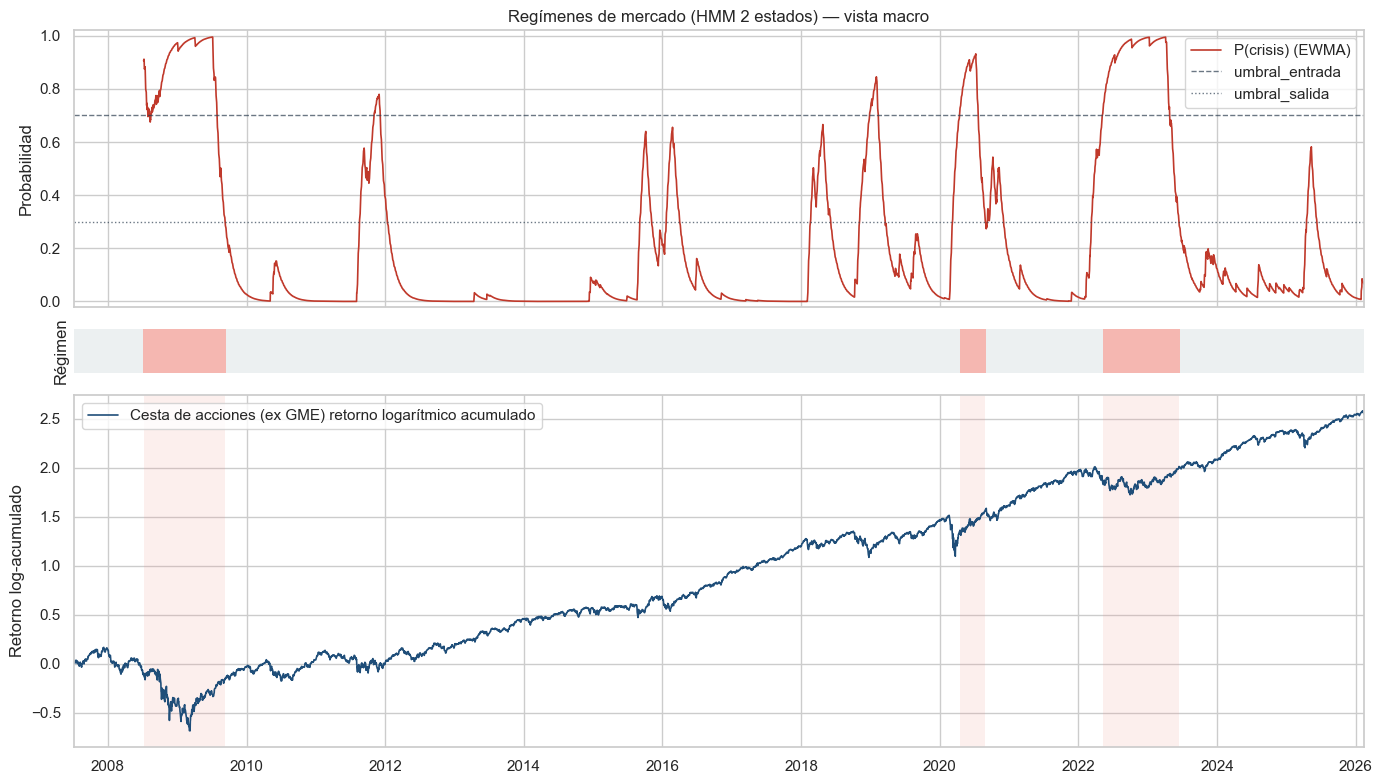

Segmentos sombreados (crisis): 3


In [8]:
# --- Gráficos (estilo informe): probabilidad + banda de régimen + cesta de acciones ---

# Configurar tema visual para los gráficos
sns.set_theme(style="whitegrid")

# ---- Controles de presentación (macro + cobertura 2008) ----
# Se prioriza una señal macro estable que conserve el bloque 2008-2009 en el panel CORE.
# Se prueba una cuadrícula de sensibilidad y se elige la primera configuración que detecte crisis en 2008.
PARAM_CANDIDATES = [
    {"name": "macro_strict", "smooth_span": 60, "enter": 0.70, "exit": 0.30, "min_days": 60, "max_gap": 10},
    {"name": "balanced", "smooth_span": 30, "enter": 0.60, "exit": 0.40, "min_days": 30, "max_gap": 8},
    {"name": "sensitive_2008", "smooth_span": 20, "enter": 0.55, "exit": 0.35, "min_days": 20, "max_gap": 6},
    {"name": "very_sensitive", "smooth_span": 15, "enter": 0.50, "exit": 0.35, "min_days": 15, "max_gap": 5},
]
# Fechas objetivo para capturar la crisis de 2008
TARGET_2008_START = pd.Timestamp("2008-09-01")
TARGET_2008_END = pd.Timestamp("2009-06-30")

def _runs_to_segments(flags: pd.Series) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """Convierte series de banderas booleanas en segmentos de tiempo continuos.
    
    Args:
        flags: Serie booleana que indica períodos de crisis
        
    Returns:
        Lista de tuplas (inicio, fin) para cada segmento continuo de True
    """
    flags = flags.astype(bool)
    if len(flags) == 0:
        return []
    x = flags.to_numpy(copy=True)
    idx = flags.index
    # Detectar cambios de estado
    chg = np.flatnonzero(x[1:] != x[:-1]) + 1
    starts = np.r_[0, chg]
    ends = np.r_[chg, len(x)]
    segs = []
    # Extraer solo segmentos donde el estado es True (crisis)
    for s, e in zip(starts, ends):
        if x[s]:
            segs.append((idx[s], idx[e - 1]))
    return segs

def clean_regime_flags(flags: pd.Series, *, min_true: int, max_false_gap: int) -> pd.Series:
    """Post-procesa regímenes booleanos para evitar gráficos tipo 'código de barras'.
    
    Elimina ruido en las señales de crisis mediante dos reglas:
    - Rellena gaps cortos de False dentro de corridas de True (<= max_false_gap)
    - Elimina corridas cortas de True (< min_true)
    
    Args:
        flags: Serie booleana original de regímenes
        min_true: Duración mínima en días para considerar una crisis válida
        max_false_gap: Máximo número de días falsos permitidos dentro de una crisis
        
    Returns:
        Serie booleana limpia y estabilizada
    """
    flags = flags.astype(bool).copy()
    x = flags.to_numpy(copy=True)
    n = len(x)
    if n == 0:
        return flags

    def _rle(arr: np.ndarray):
        """Run-length encoding: codifica secuencias consecutivas iguales."""
        chg = np.flatnonzero(arr[1:] != arr[:-1]) + 1
        starts = np.r_[0, chg]
        ends = np.r_[chg, n]
        vals = arr[starts]
        lens = ends - starts
        return starts, ends, vals, lens

    # 1) Rellenar gaps cortos de False rodeados de True
    starts, ends, vals, lens = _rle(x)
    for s, e, v, L in zip(starts, ends, vals, lens):
        if (not v) and (L <= max_false_gap):
            left_true = (s > 0) and x[s - 1]
            right_true = (e < n) and x[e]
            if left_true and right_true:
                x[s:e] = True

    # 2) Eliminar corridas cortas de True
    starts, ends, vals, lens = _rle(x)
    for s, e, v, L in zip(starts, ends, vals, lens):
        if v and (L < min_true):
            x[s:e] = False

    return pd.Series(x, index=flags.index, name=flags.name)

def hysteresis_flags(p: pd.Series, *, enter: float, exit: float) -> pd.Series:
    """Convierte una serie de probabilidades en un régimen booleano estable usando histéresis.
    
    La histéresis evita cambios frecuentes de estado usando umbrales diferentes
    para entrar y salir de crisis.
    
    Args:
        p: Serie de probabilidades de crisis
        enter: Umbral para entrar en estado de crisis
        exit: Umbral para salir de estado de crisis (debe ser < enter)
        
    Returns:
        Serie booleana indicando períodos de crisis
    """
    p = p.astype(float)
    out = np.zeros(len(p), dtype=bool)
    in_crisis = False
    for i, val in enumerate(p.to_numpy()):
        if not np.isfinite(val):
            out[i] = in_crisis
            continue
        # Lógica de histéresis: requiere umbral más alto para entrar, más bajo para salir
        if (not in_crisis) and (val >= enter):
            in_crisis = True
        elif in_crisis and (val <= exit):
            in_crisis = False
        out[i] = in_crisis
    return pd.Series(out, index=p.index, name="is_crisis_hysteresis")

def _build_crisis_flags(
    p: pd.Series,
    *,
    smooth_span: int,
    enter: float,
    exit: float,
    min_days: int,
    max_gap: int,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """Construye banderas de crisis aplicando suavizado, histéresis y limpieza.
    
    Pipeline completo para generar señales de crisis robustas:
    1. Suavizado exponencial ponderado (EWMA)
    2. Histéresis para evitar cambios frecuentes
    3. Limpieza de ruido
    
    Args:
        p: Serie de probabilidades crudas del HMM
        smooth_span: Período de suavizado EWMA
        enter: Umbral de entrada a crisis
        exit: Umbral de salida de crisis
        min_days: Duración mínima de crisis
        max_gap: Gap máximo permitido dentro de crisis
        
    Returns:
        Tupla: (probabilidades_suavizadas, banderas_crudas, banderas_limpias)
    """
    # Suavizar probabilidades con media móvil exponencial ponderada
    p_smooth = p.ewm(span=smooth_span, adjust=False).mean()
    # Aplicar histéresis para obtener banderas iniciales
    raw = hysteresis_flags(p_smooth, enter=enter, exit=exit)
    # Limpiar ruido y estabilizar señales
    clean = clean_regime_flags(raw, min_true=min_days, max_false_gap=max_gap)
    return p_smooth, raw, clean

# Búsqueda automática de configuración que capture la crisis de 2008
selected_cfg = None
selected_pack = None
for cfg in PARAM_CANDIDATES:
    p_smooth_i, raw_i, clean_i = _build_crisis_flags(
        regime["p_crisis"],
        smooth_span=cfg["smooth_span"],
        enter=cfg["enter"],
        exit=cfg["exit"],
        min_days=cfg["min_days"],
        max_gap=cfg["max_gap"],
    )
    # Verificar si la configuración captura el período de crisis 2008
    window_i = clean_i.loc[(clean_i.index >= TARGET_2008_START) & (clean_i.index <= TARGET_2008_END)]
    captures_2008 = bool(window_i.any()) if len(window_i) else False
    if captures_2008:
        selected_cfg = cfg
        selected_pack = (p_smooth_i, raw_i, clean_i)
        break

# Plan B: usar la configuración más sensible si ninguna detecta 2008
if selected_cfg is None:
    selected_cfg = PARAM_CANDIDATES[-1]
    selected_pack = _build_crisis_flags(
        regime["p_crisis"],
        smooth_span=selected_cfg["smooth_span"],
        enter=selected_cfg["enter"],
        exit=selected_cfg["exit"],
        min_days=selected_cfg["min_days"],
        max_gap=selected_cfg["max_gap"],
    )

# Extraer resultados de la configuración seleccionada
p_crisis_smooth, is_crisis_raw, is_crisis = selected_pack

# Exponer parámetros finales (se usan también en el gráfico)
SMOOTH_SPAN = selected_cfg["smooth_span"]
ENTER_CRISIS = selected_cfg["enter"]
EXIT_CRISIS = selected_cfg["exit"]
MIN_CRISIS_DAYS = selected_cfg["min_days"]
MAX_FALSE_GAP = selected_cfg["max_gap"]

# Validación y diagnóstico de la configuración seleccionada
window = is_crisis.loc[(is_crisis.index >= TARGET_2008_START) & (is_crisis.index <= TARGET_2008_END)]
print(
    f"Configuración de sombreado de crisis: {selected_cfg['name']} "
    f"(span={SMOOTH_SPAN}, enter={ENTER_CRISIS:.2f}, exit={EXIT_CRISIS:.2f}, "
    f"min_days={MIN_CRISIS_DAYS}, max_gap={MAX_FALSE_GAP})"
)
if len(window):
    print(f"Días marcados como crisis en ventana 2008: {int(window.sum())} / {len(window)}")

# ---- Diseño de figura: probabilidad (arriba) + banda delgada de régimen (medio) + cesta de acciones (abajo) ----
fig, (ax_p, ax_band, ax_spy) = plt.subplots(
    3, 1, figsize=(14, 8), sharex=True, gridspec_kw={"height_ratios": [2.2, 0.35, 2.8]}
)

# Panel superior: probabilidad de crisis
ax_p.plot(regime.index, p_crisis_smooth, color="#c0392b", linewidth=1.2, label="P(crisis) (EWMA)")
ax_p.axhline(ENTER_CRISIS, color="#2c3e50", linestyle="--", linewidth=1, alpha=0.7, label="umbral_entrada")
ax_p.axhline(EXIT_CRISIS, color="#2c3e50", linestyle=":", linewidth=1, alpha=0.7, label="umbral_salida")
ax_p.set_ylim(-0.02, 1.02)
ax_p.set_ylabel("Probabilidad")
ax_p.set_title("Regímenes de mercado (HMM 2 estados) — vista macro")
ax_p.legend(loc="upper right", frameon=True)

# Panel medio: banda de régimen (limpia, legible)
x0 = mdates.date2num(is_crisis.index[0])
x1 = mdates.date2num(is_crisis.index[-1])
band = is_crisis.astype(int).to_numpy()[None, :]  # forma (1, T)
cmap = ListedColormap(["#ecf0f1", "#f5b7b1"])  # normal, crisis
ax_band.imshow(band, aspect="auto", interpolation="nearest", cmap=cmap, extent=[x0, x1, 0, 1])
ax_band.set_yticks([])
ax_band.set_ylabel("Régimen")
ax_band.set_ylim(0, 1)
ax_band.grid(False)
# Ocultar bordes para apariencia limpia
for spine in ax_band.spines.values():
    spine.set_visible(False)

# Panel inferior: retorno logarítmico acumulado de la cesta de acciones
basket_lr = returns_hmm[EQUITY_TICKERS_HMM].mean(axis=1).cumsum()
ax_spy.plot(
    basket_lr.index,
    basket_lr.values,
    color="#1f4e79",
    linewidth=1.2,
    label="Cesta de acciones (ex GME) retorno logarítmico acumulado",
)
ax_spy.set_ylabel("Retorno log-acumulado")
ax_spy.legend(loc="upper left", frameon=True)

# Sombreado ligero también en el panel inferior (refuerza interpretación)
for a, b in _runs_to_segments(is_crisis):
    ax_spy.axvspan(a, b, color="#f1948a", alpha=0.15, linewidth=0)

# Formato del eje X (único eje en la parte inferior)
locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
ax_spy.xaxis.set_major_locator(locator)
ax_spy.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
# Ocultar etiquetas de fecha en paneles superiores
ax_p.tick_params(labelbottom=False)
ax_band.tick_params(labelbottom=False)

plt.tight_layout()
plt.show()

print("Segmentos sombreados (crisis):", len(_runs_to_segments(is_crisis)))

### Fase 1 - S&P 500 por régimen detectado

Visual de control del modelo de estados:

- Blanco = Calma
- Azul = Crisis

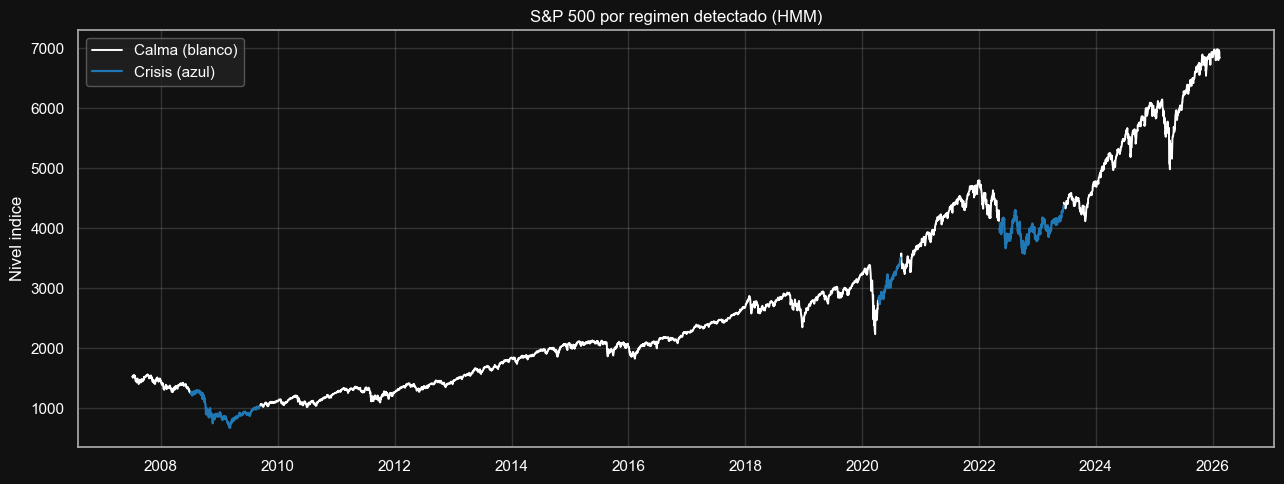

In [9]:
# --- Fase 1: S&P 500 coloreado por regimen (Blanco=Calma, Azul=Crisis) ---

spx = yf.download("^GSPC", start=START, end=END, progress=False, auto_adjust=False)
if isinstance(spx.columns, pd.MultiIndex):
    if ("Adj Close", "^GSPC") in spx.columns:
        spx_close = spx[("Adj Close", "^GSPC")]
    else:
        spx_close = spx[("Close", "^GSPC")]
else:
    spx_close = spx["Adj Close"] if "Adj Close" in spx.columns else spx["Close"]

spx_close = spx_close.reindex(regime.index).ffill().dropna()
reg_spx = is_crisis.reindex(spx_close.index).astype("boolean").fillna(False).astype(bool)

spx_calm = spx_close.where(~reg_spx)
spx_crisis = spx_close.where(reg_spx)

fig, ax = plt.subplots(figsize=(13, 5))
ax.set_facecolor("#111111")
fig.patch.set_facecolor("#111111")

# Linea base tenue + tramos coloreados por regimen
ax.plot(spx_close.index, spx_close.values, color="#666666", linewidth=0.8, alpha=0.6)
ax.plot(spx_calm.index, spx_calm.values, color="white", linewidth=1.4, label="Calma (blanco)")
ax.plot(spx_crisis.index, spx_crisis.values, color="#1f77b4", linewidth=1.6, label="Crisis (azul)")

ax.set_title("S&P 500 por regimen detectado (HMM)", color="white")
ax.set_ylabel("Nivel indice", color="white")
ax.grid(alpha=0.18)
ax.tick_params(colors="white")
for spine in ax.spines.values():
    spine.set_color("#AAAAAA")

leg = ax.legend(loc="upper left", frameon=True)
leg.get_frame().set_facecolor("#222222")
leg.get_frame().set_edgecolor("#666666")
for txt in leg.get_texts():
    txt.set_color("white")

plt.tight_layout()
plt.show()


## Cómo leer la tabla de drivers por bloque de crisis

Los drivers son señales estadísticas (no causalidad estricta) que indican qué variables se desviaron más frente al estado normal.

Para cada bloque continuo `is_crisis=True`, se calcula z-score de cada feature respecto al período normal:

- `z > 0`: feature por encima de lo normal
- `z < 0`: feature por debajo de lo normal
- `|z|` alto: variable candidata a explicar ese episodio

Ejemplos económicos:

- `dd_equity` muy negativo -> drawdown profundo de renta variable
- `vol_equity_21` alto -> fuerte inestabilidad en equity
- `vol_hy_21` alto -> tensión de crédito
- `r_credit` muy negativo -> entorno risk-off


In [10]:
# --- Diagnósticos: por qué se marca cada 'bloque de crisis' (atribución de características) ---

# Hacer que las columnas de texto largo sean legibles en las visualizaciones del notebook
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 0)
pd.set_option("display.max_columns", 200)

def segments_from_flags(flags: pd.Series) -> pd.DataFrame:
    """Convierte banderas de crisis en segmentos de tiempo continuos.
    
    Args:
        flags: Serie booleana donde True indica crisis
        
    Returns:
        DataFrame con segmentos de crisis (inicio, fin, duración)
    """
    segs = _runs_to_segments(flags)
    if not segs:
        return pd.DataFrame(columns=["start", "end", "n_days"])
    out = []
    for a, b in segs:
        idx_seg = flags.loc[a:b].index
        out.append({"start": a, "end": b, "n_days": int(len(idx_seg))})
    return pd.DataFrame(out)

# Obtener segmentos de crisis a partir de las banderas
seg_tbl = segments_from_flags(is_crisis)
if seg_tbl.empty:
    print("No se encontraron segmentos de crisis.")
else:
    # Columnas de características a reportar (solo las principales para mantener interpretabilidad)
    cols_preferred = [
        "vol_equity_21",  # Volatilidad de acciones a 21 días
        "dd_equity",      # Drawdown de acciones
        "r_credit",       # Retorno de crédito
        "vol_hy_21",      # Volatilidad de high yield a 21 días
        "r_equity",       # Retorno de acciones
        "r_hy",           # Retorno de high yield
        "r_10y",          # Retorno de bonos a 10 años
        "r_2y",           # Retorno de bonos a 2 años
        "r_gld",          # Retorno de oro
    ]
    feat_cols = [c for c in cols_preferred if c in features.columns]
    feat = features[feat_cols].copy()

    # Línea base normal = todas las fechas que no están en crisis (para z-scores)
    normal_mask = ~is_crisis.reindex(feat.index, fill_value=False)
    mu0 = feat.loc[normal_mask].mean()  # Media en períodos normales
    sd0 = feat.loc[normal_mask].std(ddof=1).replace(0, np.nan)  # Desviación estándar en períodos normales

    rows = []
    for _, row in seg_tbl.iterrows():
        a, b = row["start"], row["end"]
        seg = feat.loc[a:b]
        m = seg.mean()  # Media del segmento de crisis
        z = (m - mu0) / sd0  # Z-score respecto a períodos normales
        z = z.replace([np.inf, -np.inf], np.nan)
        top = z.abs().sort_values(ascending=False).head(4)  # Top 4 características más atípicas

        drivers = []
        for k in top.index:
            if pd.notna(z[k]):
                drivers.append((k, float(z[k])))
        top_txt = "; ".join([f"{k}: z={val:+.2f}" for k, val in drivers])

        base = {
            "start": a,
            "end": b,
            "n_days": int(row["n_days"]),
            "p_crisis_mean": float(p_crisis_smooth.loc[a:b].mean()),
            "p_crisis_max": float(p_crisis_smooth.loc[a:b].max()),
            "top_drivers_vs_normal": top_txt,
        }
        # Agregar los 4 principales conductores como columnas separadas
        for i in range(4):
            if i < len(drivers):
                base[f"driver_{i+1}"] = drivers[i][0]
                base[f"z_{i+1}"] = drivers[i][1]
            else:
                base[f"driver_{i+1}"] = ""
                base[f"z_{i+1}"] = np.nan
        rows.append(base)

    diag = pd.DataFrame(rows)
    diag["start"] = diag["start"].dt.date
    diag["end"] = diag["end"].dt.date
    diag = diag.sort_values("start")

    # NOTA: pandas .style requiere jinja2; evitamos esa dependencia renderizando HTML directamente.
    from IPython.display import HTML, display

    css = """
<style>
table.dataframe td { vertical-align: top; }
table.dataframe td, table.dataframe th { white-space: pre-wrap; }
</style>
"""
    display(HTML(css + diag.to_html(index=False)))

    print("\nCómo leer 'top_drivers_vs_normal':")
    print("- z > 0 significa más alto que lo normal; z < 0 significa más bajo que lo normal.")
    print("- |z| grande indica que esa característica es inusual en ese segmento.")

start,end,n_days,p_crisis_mean,p_crisis_max,top_drivers_vs_normal,driver_1,z_1,driver_2,z_2,driver_3,z_3,driver_4,z_4
2008-07-07,2009-09-09,298,0.860745,0.994949,dd_equity: z=-6.83; vol_hy_21: z=+4.15; vol_equity_21: z=+3.04; r_2y: z=+0.10,dd_equity,-6.833738,vol_hy_21,4.152528,vol_equity_21,3.040697,r_2y,0.097513
2020-04-15,2020-08-28,96,0.739955,0.931820,vol_hy_21: z=+1.84; vol_equity_21: z=+1.29; dd_equity: z=-0.90; r_equity: z=+0.15,vol_hy_21,1.841863,vol_equity_21,1.292572,dd_equity,-0.903244,r_equity,0.152637
2022-05-09,2023-06-14,277,0.887538,0.994601,dd_equity: z=-2.64; vol_hy_21: z=+1.23; vol_equity_21: z=+0.81; r_2y: z=-0.09,dd_equity,-2.637680,vol_hy_21,1.227451,vol_equity_21,0.806458,r_2y,-0.085618



Cómo leer 'top_drivers_vs_normal':
- z > 0 significa más alto que lo normal; z < 0 significa más bajo que lo normal.
- |z| grande indica que esa característica es inusual en ese segmento.


## Fase 2 - Riesgo marginal por estado

Objetivo: medir cómo cambian las distribuciones individuales en Normal vs Estrés.

Se reporta por activo y estado:

- media
- volatilidad
- skew
- kurtosis
- VaR y ES (1% y 5%)


Guardado: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase2_risk_by_state.csv


,ticker,state,n_days,mean,vol,VaR_5,ES_5,VaR_1,ES_1,skew,kurt
0,AAPL,Estres,671,0.001083,0.027068,-0.041352,-0.061418,-0.070248,-0.098194,-0.408044,6.021967
1,AAPL,Normal,4071,0.000933,0.018291,-0.027510,-0.042827,-0.051398,-0.070782,-0.250719,5.823895
2,AMZN,Estres,671,0.000936,0.033276,-0.049317,-0.074755,-0.095850,-0.111578,0.155441,2.758611
3,AMZN,Normal,4071,0.000965,0.021588,-0.030482,-0.047076,-0.055523,-0.077300,0.931098,14.319381
4,BAC,Estres,671,-0.000501,0.061773,-0.089365,-0.156927,-0.206950,-0.273110,-0.171712,7.128625
5,BAC,Normal,4071,0.000185,0.020788,-0.031176,-0.048660,-0.055715,-0.081886,-0.286857,10.314056
6,BRK-B,Estres,671,-0.000011,0.021687,-0.032137,-0.049781,-0.058415,-0.073670,0.708793,9.317345
7,BRK-B,Normal,4071,0.000473,0.011914,-0.016845,-0.026719,-0.030539,-0.047422,0.017960,10.128138
8,CVX,Estres,671,-0.000435,0.027774,-0.042446,-0.063293,-0.088211,-0.108062,0.269320,6.651470
9,CVX,Normal,4071,0.000466,0.016179,-0.023575,-0.036950,-0.040727,-0.065414,-1.077821,29.786362


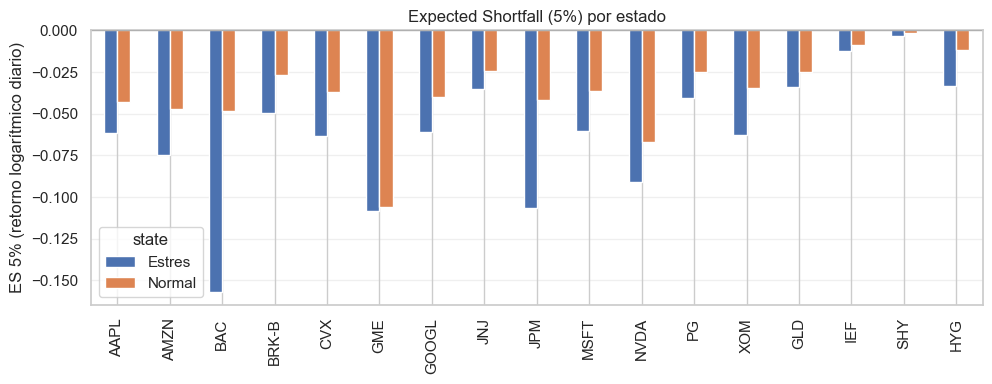

Días en Normal: 4071
Días en Estres: 671


In [11]:
# --- Fase 2: riesgo marginal por estado (Normal vs Estres) ---

# Seguridad: alinear todo en el mismo índice
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

def var_es(x: pd.Series, alpha: float) -> tuple[float, float]:
    """Calcula Value at Risk (VaR) y Expected Shortfall (ES).
    
    Args:
        x: Serie de retornos
        alpha: Nivel de confianza (ej. 0.05 para 5%)
        
    Returns:
        tuple: (VaR, ES)
    """
    x = x.dropna()
    if len(x) == 0:
        return (np.nan, np.nan)
    q = x.quantile(alpha)
    tail = x[x <= q]
    es = tail.mean() if len(tail) else np.nan
    return (float(q), float(es))

ALPHAS = [0.01, 0.05]  # Niveles de confianza: 1% y 5%
states = {"Normal": ~flags, "Estres": flags}  # Estados: Normal vs Estres

rows = []
for state_name, mask in states.items():
    sub = ret.loc[mask]  # Subset de retornos para este estado
    for ticker in ret.columns:
        x = sub[ticker].dropna()  # Retornos del ticker sin valores faltantes
        r = {
            "state": state_name,
            "ticker": ticker,
            "n_days": int(x.shape[0]),
            "mean": float(x.mean()) if len(x) else np.nan,      # Media de retornos
            "vol": float(x.std(ddof=1)) if len(x) > 1 else np.nan,  # Volatilidad
            "skew": float(x.skew()) if len(x) > 2 else np.nan,    # Asimetría
            "kurt": float(x.kurt()) if len(x) > 3 else np.nan,    # Curtosis
        }
        # Calcular VaR y ES para cada nivel de confianza
        for a in ALPHAS:
            v, e = var_es(x, a)
            r[f"VaR_{int(a*100)}"] = v  # Value at Risk
            r[f"ES_{int(a*100)}"] = e   # Expected Shortfall
        rows.append(r)

risk_by_state = pd.DataFrame(rows).sort_values(["ticker", "state"]).reset_index(drop=True)

# Guardar resultados (útil para reporte/exportación)
out_csv = OUT_DIR / "phase2_risk_by_state.csv"
risk_by_state.to_csv(out_csv, index=False)
print("Guardado:", out_csv)

# Mostrar vista compacta (tabla completa en CSV)
cols_show = ["ticker", "state", "n_days", "mean", "vol", "VaR_5", "ES_5", "VaR_1", "ES_1", "skew", "kurt"]
display(risk_by_state[cols_show].head(16))

# Visualización rápida: comparación ES(5%) por activo (Normal vs Estres)
pivot_es5 = risk_by_state.pivot(index="ticker", columns="state", values="ES_5").reindex(ret.columns)
fig, ax = plt.subplots(figsize=(10, 4))
pivot_es5.plot(kind="bar", ax=ax)
ax.axhline(0, color="black", linewidth=0.8)
ax.set_title("Expected Shortfall (5%) por estado")
ax.set_ylabel("ES 5% (retorno logarítmico diario)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Verificación opcional: cuántos días por estado
print("Días en Normal:", int((~flags).sum()))
print("Días en Estres:", int(flags.sum()))

### Lectura ejecutiva de Fase 2

Se resume de forma automática:

1. Cuánto aumenta la volatilidad de HYG al pasar de Normal a Estrés.
2. Si GLD mantiene comportamiento defensivo en períodos de estrés.

In [12]:
# --- Fase 2: respuestas automaticas (HYG y GLD) ---
phase2_q = (
    risk_by_state[risk_by_state["ticker"].isin(["HYG", "GLD"])]
    .set_index(["ticker", "state"])
    .sort_index()
)

display(
    phase2_q[["n_days", "mean", "vol", "VaR_1", "ES_1", "VaR_5", "ES_5", "skew", "kurt"]]
)

hyg_n = phase2_q.loc[("HYG", "Normal")]
hyg_s = phase2_q.loc[("HYG", "Estres")]
hyg_vol_inc_pct = (hyg_s["vol"] / hyg_n["vol"] - 1.0) * 100.0

print(
    f"HYG: vol Normal={hyg_n['vol']:.6f} vs Estres={hyg_s['vol']:.6f} "
    f"-> aumento = {hyg_vol_inc_pct:.2f}% (x{hyg_s['vol']/hyg_n['vol']:.2f})."
)

gld_n = phase2_q.loc[("GLD", "Normal")]
gld_s = phase2_q.loc[("GLD", "Estres")]

gld_checks = {
    "mean_positive_in_stress": bool(gld_s["mean"] > 0),
    "vol_not_higher_in_stress": bool(gld_s["vol"] <= gld_n["vol"]),
    "ES5_not_worse_in_stress": bool(abs(gld_s["ES_5"]) <= abs(gld_n["ES_5"])),
    "VaR1_not_worse_in_stress": bool(abs(gld_s["VaR_1"]) <= abs(gld_n["VaR_1"])),
}
score = sum(gld_checks.values())

if score >= 3:
    gld_conclusion = "Sí: GLD actúa como refugio (al menos parcial) en este corte."
elif score == 2:
    gld_conclusion = "Mixto: GLD no empeora claramente, pero la señal de refugio no es concluyente."
else:
    gld_conclusion = "No: GLD no se comporta como refugio en este corte."

print("GLD checks:", gld_checks)
print(gld_conclusion)


n_days      mean       vol     VaR_1      ES_1     VaR_5  \
ticker state                                                              
GLD    Estres     671  0.000310  0.014813 -0.040888 -0.056420 -0.020992   
       Normal    4071  0.000423  0.010553 -0.029320 -0.041569 -0.016704   
HYG    Estres     671  0.000120  0.013562 -0.043266 -0.058394 -0.017925   
       Normal    4071  0.000205  0.005018 -0.013776 -0.022272 -0.006863   

                   ES_5      skew       kurt  
ticker state                                  
GLD    Estres -0.034152  0.249470   6.864399  
       Normal -0.025225 -0.693201   6.823075  
HYG    Estres -0.033594  0.399241  14.285429  
       Normal -0.011957 -0.301902  22.011702

HYG: vol Normal=0.005018 vs Estres=0.013562 -> aumento = 170.27% (x2.70).
GLD checks: {'mean_positive_in_stress': True, 'vol_not_higher_in_stress': False, 'ES5_not_worse_in_stress': False, 'VaR1_not_worse_in_stress': False}
No: GLD no se comporta como refugio en este corte.


### Distribuciones Normal vs Estrés

Visual comparativo de histogramas por activo para revisar cambios en forma, dispersión y cola izquierda.

Para legibilidad, el eje X se acota a percentiles centrales, manteniendo referencias de VaR(5%) y VaR(1%).


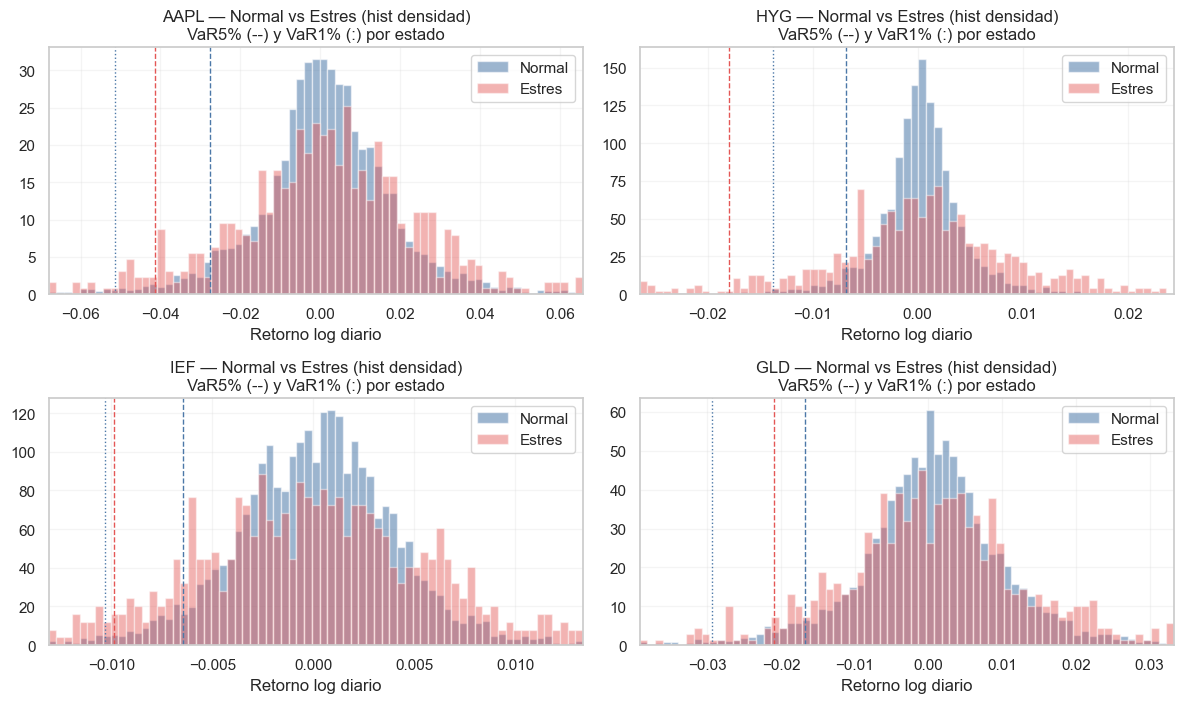

In [13]:
# --- Phase 2 (extra figure): return distributions by state ---

# Reuse objects from Phase 2
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

# Pick a few representative assets (risk + defensive)
if "EQUITY_TICKERS" in globals() and EQUITY_TICKERS:
    equity_anchor = EQUITY_TICKERS[0]
else:
    equity_anchor = ret.columns[0] if len(ret.columns) else None

hy_ticker = HY_TICKER if "HY_TICKER" in globals() else None
bond10_ticker = BOND_10Y_TICKER if "BOND_10Y_TICKER" in globals() else None
gold_ticker = GOLD_TICKER if "GOLD_TICKER" in globals() else None

focus_candidates = [equity_anchor, hy_ticker, bond10_ticker, gold_ticker]
tickers_focus = [t for t in focus_candidates if t is not None and t in ret.columns]
if not tickers_focus:
    tickers_focus = list(ret.columns[:4])

def _safe_quantile(x, q, default=np.nan):
    x = pd.Series(x).dropna()
    return float(x.quantile(q)) if len(x) else default

n = len(tickers_focus)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.6 * nrows))
axes = np.array(axes).reshape(-1)

for ax, t in zip(axes, tickers_focus):
    xN = ret.loc[~flags, t].dropna()
    xS = ret.loc[flags, t].dropna()
    x_all = pd.concat([xN, xS], axis=0)

    # Central window for readability (still marking VaR lines)
    q_lo = _safe_quantile(x_all, 0.005)
    q_hi = _safe_quantile(x_all, 0.995)
    if np.isfinite(q_lo) and np.isfinite(q_hi) and q_hi > q_lo:
        bins = np.linspace(q_lo, q_hi, 70)
        ax.set_xlim(q_lo, q_hi)
    else:
        bins = 70

    ax.hist(xN, bins=bins, density=True, alpha=0.55, color="#4C78A8", label="Normal")
    ax.hist(xS, bins=bins, density=True, alpha=0.45, color="#E45756", label="Estres")

    # Mark VaR lines (5% dashed, 1% dotted)
    v5N, _ = var_es(xN, 0.05)
    v1N, _ = var_es(xN, 0.01)
    v5S, _ = var_es(xS, 0.05)
    v1S, _ = var_es(xS, 0.01)

    if np.isfinite(v5N):
        ax.axvline(v5N, color="#4C78A8", linestyle="--", linewidth=1)
    if np.isfinite(v1N):
        ax.axvline(v1N, color="#4C78A8", linestyle=":", linewidth=1)
    if np.isfinite(v5S):
        ax.axvline(v5S, color="#E45756", linestyle="--", linewidth=1)
    if np.isfinite(v1S):
        ax.axvline(v1S, color="#E45756", linestyle=":", linewidth=1)

    ax.set_title(f"{t} — Normal vs Estres (hist densidad)\nVaR5% (--) y VaR1% (:) por estado")
    ax.set_xlabel("Retorno log diario")
    ax.grid(alpha=0.2)
    ax.legend()

# Hide unused axes
for ax in axes[len(tickers_focus):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


## Fase 3 - Dependencia entre activos

Objetivo: analizar cómo se deteriora la diversificacion en estrés.

Secuencia de trabajo:

1. Correlaciones por estado (dependencia lineal).
2. Dependencia en cola empírica (co-movimientos extremos).
3. Ajuste de cópulas (gaussiana y t) por estado.


[Aviso] max |Δ| = 0.308 supera ±0.15; el panel Δ saturará colores.


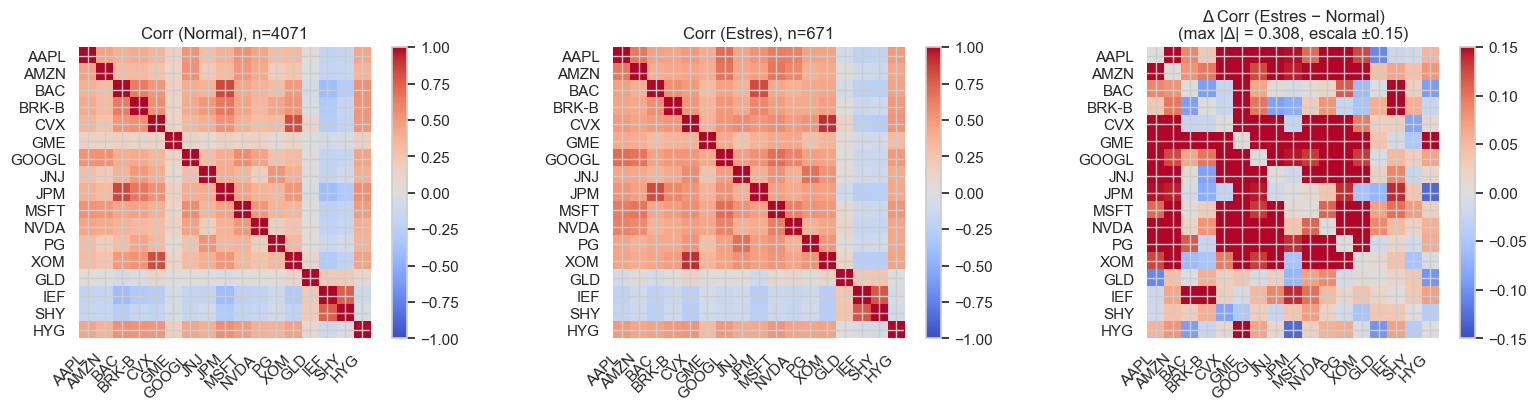

,abs_delta,delta,asset_a,asset_b
0,0.308470,0.308470,GME,GOOGL
1,0.296289,0.296289,GME,NVDA
2,0.294617,0.294617,GME,MSFT
3,0.270136,0.270136,AMZN,GME
4,0.258976,0.258976,AAPL,GME
5,0.255025,0.255025,CVX,GME
6,0.243245,0.243245,GME,PG
7,0.236307,0.236307,BRK-B,GME
8,0.231553,0.231553,GME,XOM
9,0.231021,0.231021,GME,JPM


,AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG
AAPL,0.000,0.203,0.088,0.032,0.152,0.259,0.173,0.155,0.147,0.106,0.169,0.149,0.126,-0.107,-0.020,-0.016,0.054
AMZN,0.203,0.000,0.079,0.098,0.190,0.270,0.124,0.222,0.143,0.153,0.164,0.198,0.159,0.042,0.065,0.039,0.076
BAC,0.088,0.079,0.000,-0.089,-0.026,0.173,0.065,0.008,-0.010,0.005,0.018,0.115,-0.062,-0.004,0.179,0.027,-0.089
BRK-B,0.032,0.098,-0.089,0.000,-0.024,0.236,0.100,-0.087,-0.077,0.029,0.079,-0.025,-0.051,0.059,0.163,0.058,-0.026
CVX,0.152,0.190,-0.026,-0.024,0.000,0.255,0.180,0.174,-0.029,0.174,0.187,0.206,0.095,0.024,0.026,-0.084,0.012
GME,0.259,0.270,0.173,0.236,0.255,0.000,0.308,0.210,0.231,0.295,0.296,0.243,0.232,0.037,-0.011,-0.048,0.168
GOOGL,0.173,0.124,0.065,0.100,0.180,0.308,0.000,0.185,0.144,0.133,0.154,0.205,0.132,-0.006,0.048,0.026,0.066
JNJ,0.155,0.222,0.008,-0.087,0.174,0.210,0.185,0.000,-0.016,0.185,0.212,0.170,0.150,0.022,0.089,-0.023,0.017
JPM,0.147,0.143,-0.010,-0.077,-0.029,0.231,0.144,-0.016,0.000,0.012,0.037,0.138,-0.053,-0.068,0.139,0.035,-0.130
MSFT,0.106,0.153,0.005,0.029,0.174,0.295,0.133,0.185,0.012,0.000,0.110,0.179,0.183,0.070,0.103,0.071,0.024


In [14]:
# --- Phase 3a: correlation by state (Normal vs Stress) ---

ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

retN = ret.loc[~flags].dropna(how="all")
retS = ret.loc[flags].dropna(how="all")

corrN = retN.corr()
corrS = retS.corr()

# Difference heatmap (Stress - Normal)
corrD = corrS - corrN

def _heatmap(ax, M, title, vmin=-1, vmax=1, cmap="coolwarm"):
    im = ax.imshow(M.values, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_xticks(range(M.shape[1]))
    ax.set_yticks(range(M.shape[0]))
    ax.set_xticklabels(M.columns, rotation=45, ha="right")
    ax.set_yticklabels(M.index)
    ax.set_title(title)
    for spine in ax.spines.values():
        spine.set_visible(False)
    return im

# Fixed delta scale (case-specific): vivid and comparable within this report
max_abs_delta = float(np.nanmax(np.abs(corrD.values)))
delta_lim = 0.15  # choose a "reasonable" fixed scale for this dataset/report
if max_abs_delta > delta_lim:
    print(f"[Aviso] max |Δ| = {max_abs_delta:.3f} supera ±{delta_lim:.2f}; el panel Δ saturará colores.")

fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
im0 = _heatmap(axes[0], corrN, f"Corr (Normal), n={len(retN)}")
im1 = _heatmap(axes[1], corrS, f"Corr (Estres), n={len(retS)}")
im2 = _heatmap(
    axes[2],
    corrD,
    f"Δ Corr (Estres − Normal)\n(max |Δ| = {max_abs_delta:.3f}, escala ±{delta_lim:.2f})",
    vmin=-delta_lim,
    vmax=delta_lim,
)

fig.colorbar(im0, ax=axes[0], fraction=0.046)
fig.colorbar(im1, ax=axes[1], fraction=0.046)
fig.colorbar(im2, ax=axes[2], fraction=0.046)
plt.show()

# Show the largest absolute changes (upper triangle)
pairs = []
cols = list(corrD.columns)
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        a, b = cols[i], cols[j]
        v = float(corrD.loc[a, b])
        pairs.append((abs(v), v, a, b))

top = sorted(pairs, key=lambda t: t[0], reverse=True)[:10]
display(pd.DataFrame(top, columns=["abs_delta", "delta", "asset_a", "asset_b"]))

display(corrD.round(3))


### 3b) Dependencia en cola (empírica)

La correlación central no captura bien episodios extremos.

Se estima para cuantiles bajos `q`:

`lambda_L(q) = P(R_i <= Q_i(q), R_j <= Q_j(q)) / q`

Interpretación: cuanto mas alto `lambda_L`, mayor probabilidad de caidas conjuntas en la cola izquierda.


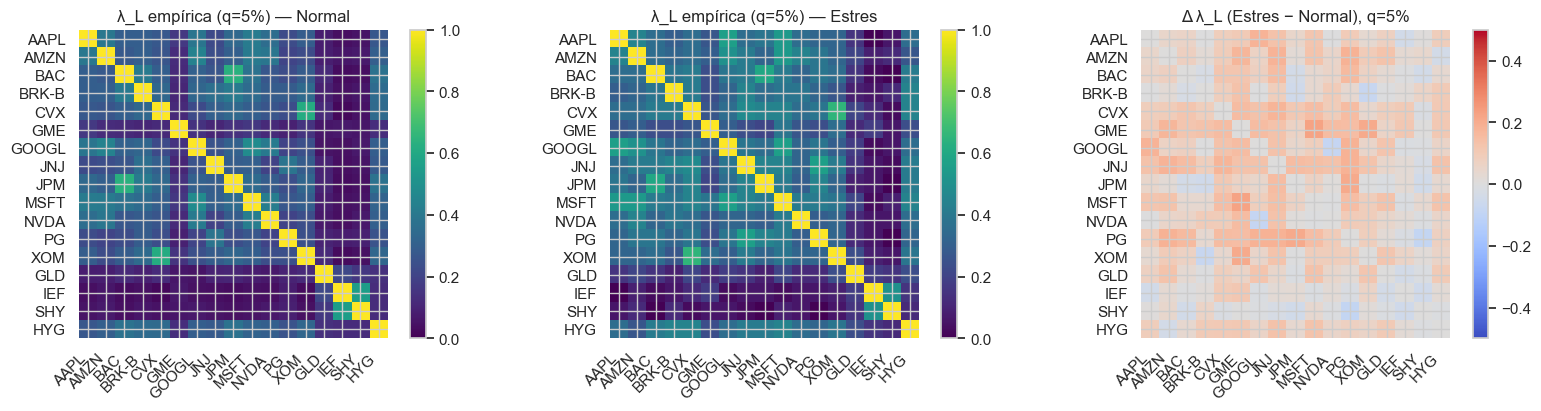

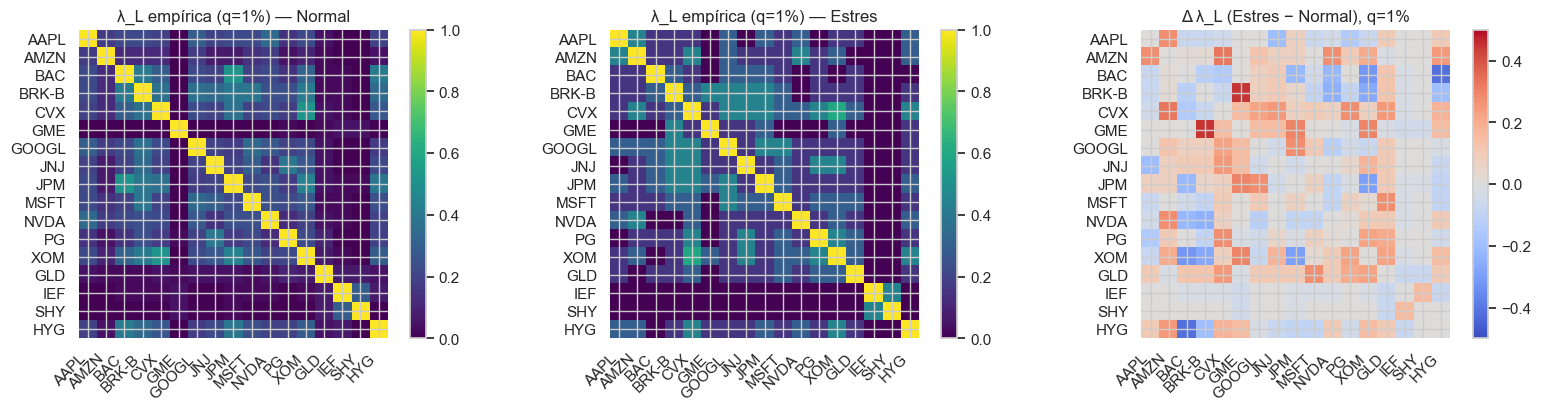

Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase3_taildep_empirical_normal_q5.csv
Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase3_taildep_empirical_normal_q1.csv
Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase3_taildep_empirical_estres_q5.csv
Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase3_taildep_empirical_estres_q1.csv


,delta_lambda,asset_a,asset_b
0,0.225359,GME,MSFT
1,0.206367,JPM,PG
2,0.205378,GME,XOM
3,0.183121,JNJ,PG
4,0.181144,AMZN,PG
5,0.181144,GOOGL,PG
6,0.178208,AAPL,GOOGL
7,0.176561,AMZN,JNJ
8,0.172307,CVX,JNJ
9,0.170330,AMZN,GME


In [15]:
# --- Phase 3b: empirical lower-tail dependence by state ---

ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

states = {"Normal": ~flags, "Estres": flags}
qs = [0.05, 0.01]

assets = list(ret.columns)

def empirical_lambda_L(sub: pd.DataFrame, q: float) -> pd.DataFrame:
    sub = sub.dropna(how="all")
    out = pd.DataFrame(index=assets, columns=assets, dtype=float)

    # Diagonal: perfect self-dependence
    for a in assets:
        out.loc[a, a] = 1.0

    # Off-diagonals
    for i, a in enumerate(assets):
        for j in range(i + 1, len(assets)):
            b = assets[j]
            x = sub[[a, b]].dropna()
            if len(x) < 50:
                out.loc[a, b] = np.nan
                out.loc[b, a] = np.nan
                continue

            qa = float(x[a].quantile(q))
            qb = float(x[b].quantile(q))
            ind = (x[a].to_numpy() <= qa) & (x[b].to_numpy() <= qb)
            p = float(ind.mean())
            val = p / q if q > 0 else np.nan
            out.loc[a, b] = val
            out.loc[b, a] = val

    return out

lam = {}  # lam[(state, q)] -> matrix
for state_name, mask in states.items():
    sub = ret.loc[mask]
    for q in qs:
        lam[(state_name, q)] = empirical_lambda_L(sub, q)

# Plot heatmaps for q=5% and q=1% (Normal, Stress, Delta)
for q in qs:
    L_N = lam[("Normal", q)]
    L_S = lam[("Estres", q)]
    L_D = L_S - L_N

    fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
    vmin, vmax = 0.0, 1.0

    im0 = axes[0].imshow(L_N.values, vmin=vmin, vmax=vmax, cmap="viridis")
    axes[0].set_title(f"λ_L empírica (q={int(q*100)}%) — Normal")

    im1 = axes[1].imshow(L_S.values, vmin=vmin, vmax=vmax, cmap="viridis")
    axes[1].set_title(f"λ_L empírica (q={int(q*100)}%) — Estres")

    im2 = axes[2].imshow(L_D.values, vmin=-0.5, vmax=0.5, cmap="coolwarm")
    axes[2].set_title(f"Δ λ_L (Estres − Normal), q={int(q*100)}%")

    for ax in axes:
        ax.set_xticks(range(len(assets)))
        ax.set_yticks(range(len(assets)))
        ax.set_xticklabels(assets, rotation=45, ha="right")
        ax.set_yticklabels(assets)
        for spine in ax.spines.values():
            spine.set_visible(False)

    fig.colorbar(im0, ax=axes[0], fraction=0.046)
    fig.colorbar(im1, ax=axes[1], fraction=0.046)
    fig.colorbar(im2, ax=axes[2], fraction=0.046)
    plt.show()

# Export matrices (useful for report)
for (state_name, q), M in lam.items():
    out = OUT_DIR / f"phase3_taildep_empirical_{state_name.lower()}_q{int(q*100)}.csv"
    M.to_csv(out)
    print("Saved:", out)

# Quick ranking: which pairs increase most in tail dependence at q=5%
q = 0.05
L_D = lam[("Estres", q)] - lam[("Normal", q)]
pairs = []
for i, a in enumerate(assets):
    for j in range(i + 1, len(assets)):
        b = assets[j]
        v = L_D.loc[a, b]
        if np.isfinite(v):
            pairs.append((float(v), a, b))

top = sorted(pairs, key=lambda t: t[0], reverse=True)[:10]
display(pd.DataFrame(top, columns=["delta_lambda", "asset_a", "asset_b"]))


### 3c) Cópulas por estado (gaussiana vs t)

Se separan marginales y dependencia para modelar estructura conjunta de retornos:

- Cópula gaussiana: buena para dependencia media, débil en colas.
- Cópula t: más realista para extremos conjuntos.

Se exportan matrices de correlacion y (para cópula t) dependencia de cola implícita.


Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase3_copula_summary.json
{'Normal': {'n': 4071, 't_df': 10.0, 'used_multivariate_t': True}, 'Estres': {'n': 671, 't_df': 7.0, 'used_multivariate_t': True}}
[Aviso] max |Δ corr (Gauss)| = 0.216 supera ±0.15; el panel Δ corr saturará colores.
[Aviso] max |Δ λ_L (t)| = 0.232 supera ±0.15; el panel Δ λ_L saturará colores.


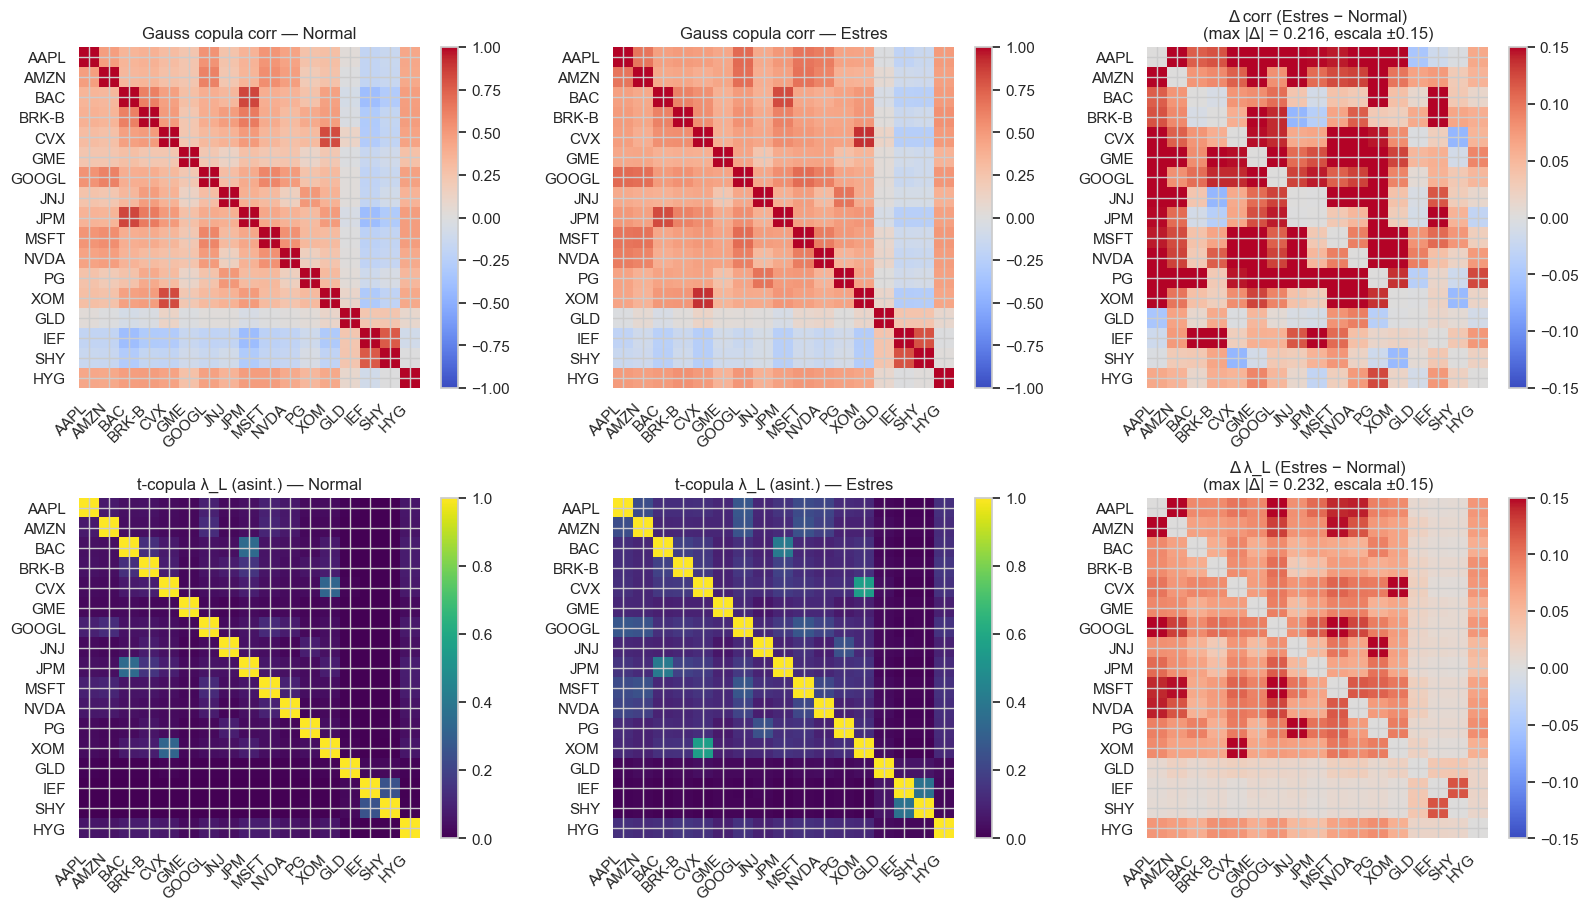

,delta_lambdaL_t,asset_a,asset_b
0,0.232369,CVX,XOM
1,0.178622,AAPL,GOOGL
2,0.164725,JNJ,PG
3,0.164248,AAPL,AMZN
4,0.150005,GOOGL,MSFT
5,0.146860,AMZN,MSFT
6,0.142304,AAPL,NVDA
7,0.140419,AAPL,MSFT
8,0.128989,AMZN,GOOGL
9,0.126444,GOOGL,NVDA


In [16]:
# --- Phase 3c: Gaussian vs t copula by state (pseudo-likelihood) ---
import json
from scipy.stats import norm, t

ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)
states = {"Normal": ~flags, "Estres": flags}
assets = list(ret.columns)

# Fixed delta scales (case-specific): improve contrast in Δ panels
DELTA_CORR_LIM = 0.15   # for Gauss copula Δ corr
DELTA_LAML_LIM = 0.15   # for t-copula Δ tail-dependence (asymptotic)

def _pseudo_obs(df: pd.DataFrame) -> np.ndarray:
    """Pseudo-observations in (0,1) via ranks columnwise."""
    x = df[assets].dropna()
    n = len(x)
    if n < 10:
        return np.empty((0, len(assets)))
    r = x.rank(method="average")
    u = (r / (n + 1.0)).to_numpy()  # avoid 0/1
    u = np.clip(u, 1e-6, 1 - 1e-6)
    return u

def _nearest_psd_corr(C: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """Project to PSD correlation matrix via eigenvalue clipping."""
    C = np.asarray(C, dtype=float)
    C = 0.5 * (C + C.T)
    np.fill_diagonal(C, 1.0)
    w, V = np.linalg.eigh(C)
    w = np.maximum(w, eps)
    C2 = (V * w) @ V.T
    d = np.sqrt(np.diag(C2))
    C2 = C2 / (d[:, None] * d[None, :])
    np.fill_diagonal(C2, 1.0)
    return 0.5 * (C2 + C2.T)

def fit_gaussian_copula(U: np.ndarray) -> np.ndarray:
    Z = norm.ppf(U)
    C = np.corrcoef(Z, rowvar=False)
    return _nearest_psd_corr(C)

def try_multivariate_t_logpdf(Z: np.ndarray, C: np.ndarray, df: float) -> np.ndarray:
    """Return log f_T(Z; C, df). Uses scipy if available."""
    try:
        from scipy.stats import multivariate_t  # type: ignore

        mv = multivariate_t(loc=np.zeros(Z.shape[1]), shape=C, df=df)
        return mv.logpdf(Z)
    except Exception as exc:
        raise RuntimeError("multivariate_t not available") from exc

def fit_t_copula(U: np.ndarray, df_grid=(3, 4, 5, 7, 10, 15, 20, 30, 50), df_fallback=5):
    """Fit t-copula by grid-search over df using pseudo log-likelihood, if scipy supports multivariate_t."""
    best = None
    best_ll = -np.inf

    can_mv_t = True
    # quick capability probe
    try:
        Z_probe = t.ppf(U[: min(len(U), 20)], df_fallback)
        C_probe = _nearest_psd_corr(np.corrcoef(Z_probe, rowvar=False))
        _ = try_multivariate_t_logpdf(Z_probe, C_probe, df_fallback)
    except Exception:
        can_mv_t = False

    if not can_mv_t:
        df = df_fallback
        Z = t.ppf(U, df)
        C = _nearest_psd_corr(np.corrcoef(Z, rowvar=False))
        return df, C, False

    for df in df_grid:
        Z = t.ppf(U, df)
        C = _nearest_psd_corr(np.corrcoef(Z, rowvar=False))
        log_joint = try_multivariate_t_logpdf(Z, C, df)
        log_marg = t.logpdf(Z, df=df).sum(axis=1)
        log_cop = log_joint - log_marg
        ll = float(np.nanmean(log_cop))
        if ll > best_ll:
            best_ll = ll
            best = (df, C)

    assert best is not None
    return best[0], best[1], True

def t_copula_taildep_lambda_L(C: np.ndarray, df: float) -> np.ndarray:
    """Asymptotic lower tail dependence for t-copula (pairwise), matrix form."""
    d = C.shape[0]
    out = np.zeros((d, d), dtype=float)
    np.fill_diagonal(out, 1.0)
    for i in range(d):
        for j in range(i + 1, d):
            rho = float(C[i, j])
            # guard numeric
            rho = max(min(rho, 0.999), -0.999)
            a = np.sqrt((df + 1.0) * (1.0 - rho) / (1.0 + rho))
            lam = 2.0 * t.cdf(-a, df=df + 1.0)
            out[i, j] = lam
            out[j, i] = lam
    return out

fits = {}
for state_name, mask in states.items():
    U = _pseudo_obs(ret.loc[mask])
    if len(U) == 0:
        continue

    Cg = fit_gaussian_copula(U)
    df_t, Ct, used_mvt = fit_t_copula(U)
    L_t = t_copula_taildep_lambda_L(Ct, df_t)

    fits[state_name] = {
        "n": int(U.shape[0]),
        "gaussian_corr": Cg,
        "t_df": float(df_t),
        "t_corr": Ct,
        "t_taildep_lambdaL": L_t,
        "used_multivariate_t": bool(used_mvt),
    }

    # Exports
    pd.DataFrame(Cg, index=assets, columns=assets).to_csv(OUT_DIR / f"phase3_copula_gaussian_corr_{state_name.lower()}.csv")
    pd.DataFrame(Ct, index=assets, columns=assets).to_csv(OUT_DIR / f"phase3_copula_t_corr_{state_name.lower()}.csv")
    pd.DataFrame(L_t, index=assets, columns=assets).to_csv(OUT_DIR / f"phase3_copula_t_taildep_lambdaL_{state_name.lower()}.csv")

# Save summary JSON
summary = {
    s: {"n": fits[s]["n"], "t_df": fits[s]["t_df"], "used_multivariate_t": fits[s]["used_multivariate_t"]}
    for s in fits
}
out_json = OUT_DIR / "phase3_copula_summary.json"
out_json.write_text(json.dumps(summary, indent=2), encoding="utf-8")
print("Saved:", out_json)
print(summary)

# Plots: Gaussian corr and t-taildep side by side (Normal vs Stress)
if "Normal" in fits and "Estres" in fits:
    CgN = pd.DataFrame(fits["Normal"]["gaussian_corr"], index=assets, columns=assets)
    CgS = pd.DataFrame(fits["Estres"]["gaussian_corr"], index=assets, columns=assets)
    LtN = pd.DataFrame(fits["Normal"]["t_taildep_lambdaL"], index=assets, columns=assets)
    LtS = pd.DataFrame(fits["Estres"]["t_taildep_lambdaL"], index=assets, columns=assets)

    dCg = (CgS - CgN)
    dLt = (LtS - LtN)
    max_abs_dCg = float(np.nanmax(np.abs(dCg.values)))
    max_abs_dLt = float(np.nanmax(np.abs(dLt.values)))
    if max_abs_dCg > DELTA_CORR_LIM:
        print(f"[Aviso] max |Δ corr (Gauss)| = {max_abs_dCg:.3f} supera ±{DELTA_CORR_LIM:.2f}; el panel Δ corr saturará colores.")
    if max_abs_dLt > DELTA_LAML_LIM:
        print(f"[Aviso] max |Δ λ_L (t)| = {max_abs_dLt:.3f} supera ±{DELTA_LAML_LIM:.2f}; el panel Δ λ_L saturará colores.")

    fig, axes = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)

    def _hm(ax, M, title, vmin, vmax, cmap):
        im = ax.imshow(M.values, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_xticks(range(len(assets)))
        ax.set_yticks(range(len(assets)))
        ax.set_xticklabels(assets, rotation=45, ha="right")
        ax.set_yticklabels(assets)
        ax.set_title(title)
        for spine in ax.spines.values():
            spine.set_visible(False)
        return im

    im = _hm(axes[0, 0], CgN, "Gauss copula corr — Normal", -1, 1, "coolwarm")
    fig.colorbar(im, ax=axes[0, 0], fraction=0.046)
    im = _hm(axes[0, 1], CgS, "Gauss copula corr — Estres", -1, 1, "coolwarm")
    fig.colorbar(im, ax=axes[0, 1], fraction=0.046)
    im = _hm(
        axes[0, 2],
        dCg,
        f"Δ corr (Estres − Normal)\n(max |Δ| = {max_abs_dCg:.3f}, escala ±{DELTA_CORR_LIM:.2f})",
        -DELTA_CORR_LIM,
        DELTA_CORR_LIM,
        "coolwarm",
    )
    fig.colorbar(im, ax=axes[0, 2], fraction=0.046)

    im = _hm(axes[1, 0], LtN, "t-copula λ_L (asint.) — Normal", 0, 1, "viridis")
    fig.colorbar(im, ax=axes[1, 0], fraction=0.046)
    im = _hm(axes[1, 1], LtS, "t-copula λ_L (asint.) — Estres", 0, 1, "viridis")
    fig.colorbar(im, ax=axes[1, 1], fraction=0.046)
    im = _hm(
        axes[1, 2],
        dLt,
        f"Δ λ_L (Estres − Normal)\n(max |Δ| = {max_abs_dLt:.3f}, escala ±{DELTA_LAML_LIM:.2f})",
        -DELTA_LAML_LIM,
        DELTA_LAML_LIM,
        "coolwarm",
    )
    fig.colorbar(im, ax=axes[1, 2], fraction=0.046)

    plt.show()

    # Quick ranking of tail-dependence increases (asymptotic) under t-copula
    D = dLt.values
    pairs = []
    for i, a in enumerate(assets):
        for j in range(i + 1, len(assets)):
            b = assets[j]
            pairs.append((float(D[i, j]), a, b))
    top = sorted(pairs, key=lambda t: t[0], reverse=True)[:10]
    display(pd.DataFrame(top, columns=["delta_lambdaL_t", "asset_a", "asset_b"]))

else:
    print("Copula fit missing a state; available:", list(fits.keys()))


### Puente Fase 3 -> Fase 4

La celda siguiente resume con evidencia cuantitativa las diferencias entre Normal y Estrés en:

- riesgo marginal,
- dependencia,
- features del HMM.

In [17]:
# --- Transicion Fase 3->4: resumen cuantitativo de diferencias entre regímenes ---
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

summary = pd.DataFrame(index=["Normal", "Estres"])
summary["n_days"] = [int((~flags).sum()), int(flags.sum())]
summary["pct_days"] = summary["n_days"] / len(flags)

# Riesgo marginal medio por estado (promediado sobre activos)
by_state = risk_by_state.groupby("state")
summary["avg_asset_vol"] = by_state["vol"].mean().reindex(summary.index)
summary["avg_abs_VaR1"] = (-by_state["VaR_1"].mean()).reindex(summary.index)
summary["avg_abs_ES1"] = (-by_state["ES_1"].mean()).reindex(summary.index)

# Dependencia lineal media
corr_n = ret.loc[~flags].corr()
corr_s = ret.loc[flags].corr()
tri = np.triu_indices_from(corr_n, k=1)
summary.loc["Normal", "avg_pair_corr"] = float(np.nanmean(corr_n.values[tri]))
summary.loc["Estres", "avg_pair_corr"] = float(np.nanmean(corr_s.values[tri]))

# Features medias del HMM por estado
feat = features.copy()
feat["state"] = np.where(flags.reindex(feat.index).astype("boolean").fillna(False).astype(bool), "Estres", "Normal")
feat_means = feat.groupby("state")[["vol_equity_21", "vol_hy_21", "dd_equity", "r_credit", "r_equity"]].mean()
for col in feat_means.columns:
    summary[col] = feat_means[col].reindex(summary.index)

# Dependencia en cola t-copula (si existe fit en ambos estados)
if "Normal" in fits and "Estres" in fits:
    LtN = np.asarray(fits["Normal"]["t_taildep_lambdaL"], dtype=float)
    LtS = np.asarray(fits["Estres"]["t_taildep_lambdaL"], dtype=float)
    summary.loc["Normal", "avg_tcopula_lambdaL"] = float(np.nanmean(LtN[tri]))
    summary.loc["Estres", "avg_tcopula_lambdaL"] = float(np.nanmean(LtS[tri]))

display(summary.round(4))

delta_pct = (summary.loc["Estres"] / summary.loc["Normal"] - 1.0) * 100.0
key_cols = ["avg_asset_vol", "avg_abs_VaR1", "avg_pair_corr", "vol_equity_21", "vol_hy_21"]
print()
print("Cambios relativos Estres vs Normal (%) en metricas clave:")
print(delta_pct[key_cols].round(2))

print()
print("Interpretacion economica (sintesis):")
print("- El estado de Estres concentra mayor volatilidad y peores colas de pérdida.")
print("- La co-movilidad media entre activos aumenta (diversificación menos efectiva).")
print("- Suben las volatilidades realizadas (equity/HY) y se profundiza el drawdown de equity.")


,n_days,pct_days,avg_asset_vol,avg_abs_VaR1,avg_abs_ES1,avg_pair_corr,vol_equity_21,vol_hy_21,dd_equity,r_credit,r_equity,avg_tcopula_lambdaL
Normal,4071,0.8585,0.0163,0.0421,0.0650,0.2185,0.0099,0.0040,-0.0305,0.0001,0.0006,0.0422
Estres,671,0.1415,0.0268,0.0772,0.0982,0.3009,0.0207,0.0113,-0.1973,0.0000,0.0004,0.1050



Cambios relativos Estres vs Normal (%) en metricas clave:
avg_asset_vol     64.08
avg_abs_VaR1      83.57
avg_pair_corr     37.71
vol_equity_21    110.05
vol_hy_21        184.46
dtype: float64

Interpretacion economica (sintesis):
- El estado de Estres concentra mayor volatilidad y peores colas de pérdida.
- La co-movilidad media entre activos aumenta (diversificación menos efectiva).
- Suben las volatilidades realizadas (equity/HY) y se profundiza el drawdown de equity.


## 4) Fase 4 - Motor de simulación (10.000 trayectorias, 6 meses)

Se implementa Monte Carlo con cambio de regimen diario mediante la matriz de transición del HMM y dependencia por cópula condicionada al estado.

Validaciones incluidas:

- wealth real vs bandas p5-p50-p95 simuladas,
- reproduccion de regímenes,
- reproducción de riesgo y dependencia (real vs simulado).


Phase4 setup: {'paths': 10000, 'horizon_days': 126, 'transition_source': 'empirical_from_flags', 'pi': [0.8584985238296078, 0.14150147617039224]}


,to_Normal,to_Estres
from_Normal,0.999018,0.000982
from_Estres,0.005944,0.994056


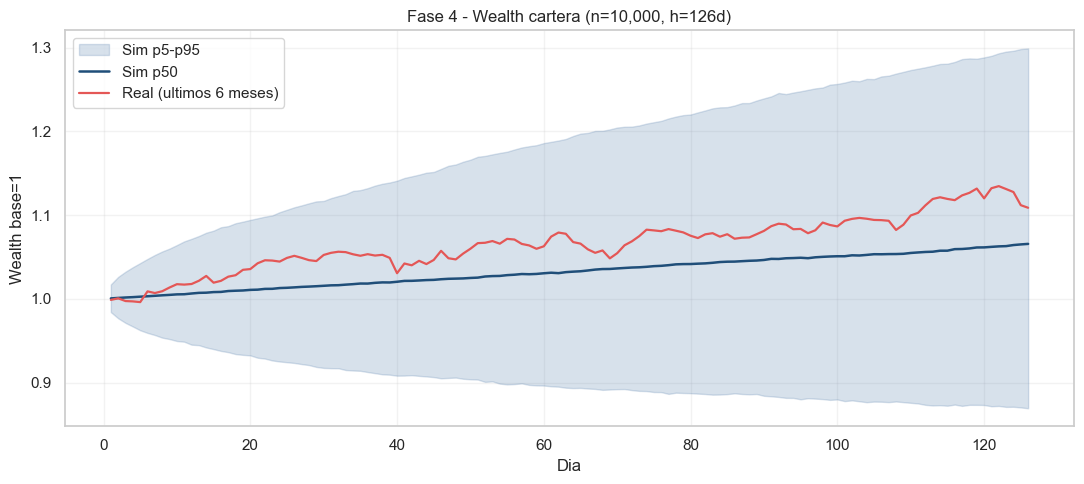

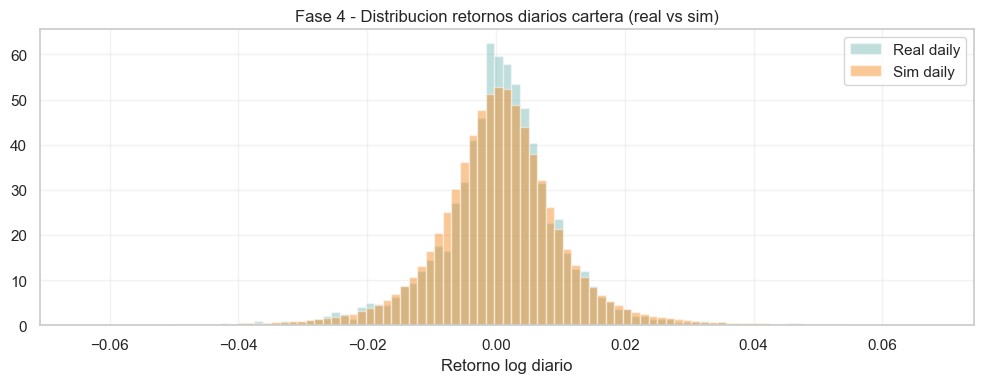

,dataset,pct_normal,pct_estres,avg_dur_normal,avg_dur_estres,n_switches,switches_252d
0,Real,0.858499,0.141501,1017.750000,223.666667,6.0000,0.318920
1,Simulado (promedio paths),0.859544,0.140456,114.663311,73.204935,0.2072,0.417715


Nota: n_switches depende del tamano de ventana. Para comparar de forma homogenea, usar switches_252d.


,dataset,vol_daily,vol_ann,max_drawdown_6m_mean,max_drawdown_6m_p95,max_drawdown_fullsample,VaR99_daily,ES99_daily,VaR99_6m,ES99_6m
0,Real,0.011064,0.175638,-0.097146,-0.028121,-0.484062,-0.031969,-0.046548,-0.282430,-0.322136
1,Simulado,0.011313,0.179592,-0.106757,-0.044327,NaN,-0.031411,-0.044917,-0.229232,-0.287200


Nota: max_drawdown_6m_* es la comparacion homogena real vs simulado a 6 meses; max_drawdown_fullsample se reporta solo como referencia historica real.


,state,n_hist,n_sim,avg_vol_hist,avg_vol_sim,avg_corr_hist,avg_corr_sim
0,Normal,4071,1083026,0.016345,0.016547,0.218493,0.211111
1,Estres,671,176974,0.026818,0.027388,0.300884,0.296780


,metric,hist,sim
0,vol_ratio_estres_vs_normal,1.640774,1.655192
1,delta_avg_corr_estres_minus_normal,0.082391,0.085668


Saved phase4 outputs in C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller


In [18]:
# --- Phase 4: regime-switching MC (10k paths, 6M horizon) ---

N_PATHS=10_000
HORIZON_DAYS=126
SEED=42
ALPHA_99=0.01
EXPORT=True

ret=returns.copy()
flags=is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)
assets=list(ret.columns)
OUT_DIR=Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('outputs_taller')
OUT_DIR.mkdir(parents=True,exist_ok=True)

def _nearest_psd_corr(C,eps=1e-8):
    C=np.asarray(C,float); C=0.5*(C+C.T); np.fill_diagonal(C,1.0)
    w,V=np.linalg.eigh(C); w=np.maximum(w,eps); C2=(V*w)@V.T
    d=np.sqrt(np.diag(C2)); C2=C2/(d[:,None]*d[None,:]); np.fill_diagonal(C2,1.0)
    return 0.5*(C2+C2.T)

def _sample_t_copula_u(n,C,df,rng):
    d=C.shape[0]; C=_nearest_psd_corr(C); L=np.linalg.cholesky(C)
    y=rng.standard_normal((n,d))@L.T; w=rng.chisquare(df,size=n)/df; z=y/np.sqrt(w)[:,None]
    u=t.cdf(z,df=df); return np.clip(u,1e-6,1-1e-6)

def _inv_empirical(u,sample):
    x=np.asarray(sample,float); x=x[np.isfinite(x)]
    if len(x)<20: return np.full_like(u,np.nan,float)
    xs=np.sort(x); p=np.arange(1,len(xs)+1)/(len(xs)+1.0)
    return np.interp(u,p,xs)

def _var_es(x,a=0.01):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    if len(x)==0: return np.nan,np.nan
    q=float(np.quantile(x,a)); tail=x[x<=q]
    return q,float(np.mean(tail)) if len(tail) else np.nan

def _mdd_logret(r):
    w=np.exp(np.cumsum(np.asarray(r,float))); peak=np.maximum.accumulate(w)
    return float(np.min(w/peak-1.0))

def _load_params():
    if 'fits' in globals() and isinstance(globals().get('fits'),dict) and len(fits)>0:
        if 'Normal' in fits and 'Estres' in fits:
            return {'Normal':{'df':float(fits['Normal']['t_df']),'Ct':np.asarray(fits['Normal']['t_corr'],float)},
                    'Estres':{'df':float(fits['Estres']['t_df']),'Ct':np.asarray(fits['Estres']['t_corr'],float)}}
    s=json.loads((OUT_DIR/'phase3_copula_summary.json').read_text(encoding='utf-8'))
    out={}
    for nm,slug in [('Normal','normal'),('Estres','estres')]:
        out[nm]={'df':float(s[nm]['t_df']),'Ct':pd.read_csv(OUT_DIR/f'phase3_copula_t_corr_{slug}.csv',index_col=0).loc[assets,assets].to_numpy()}
    return out

def _sample_state(n,Ct,df,hist_df,rng):
    if n<=0: return np.empty((0,len(assets)))
    hist=hist_df[assets].dropna(how='any')
    U=_sample_t_copula_u(n,Ct,df,rng); R=np.zeros((n,len(assets)))
    for j,a in enumerate(assets): R[:,j]=_inv_empirical(U[:,j],hist[a].to_numpy())
    return R

def _state_stats(s01):
    x=np.asarray(s01,np.int8)
    if x.size==0: return dict(pct_normal=np.nan,pct_estres=np.nan,avg_dur_normal=np.nan,avg_dur_estres=np.nan,n_switches=np.nan)
    runs=[]; cur=int(x[0]); ln=1
    for v in x[1:]:
        v=int(v)
        if v==cur: ln+=1
        else: runs.append((cur,ln)); cur=v; ln=1
    runs.append((cur,ln)); d0=[l for s,l in runs if s==0]; d1=[l for s,l in runs if s==1]
    return dict(pct_normal=float(np.mean(x==0)),pct_estres=float(np.mean(x==1)),avg_dur_normal=float(np.mean(d0)) if d0 else np.nan,avg_dur_estres=float(np.mean(d1)) if d1 else np.nan,n_switches=float(np.sum(x[1:]!=x[:-1])) if x.size>1 else 0.0)

def _simulate_states(n_paths,horizon,P,pi,rng):
    S=np.zeros((n_paths,horizon),dtype=np.int8); S[:,0]=(rng.random(n_paths)<float(pi[1])).astype(np.int8)
    for t in range(1,horizon):
        prev=S[:,t-1]; p1=np.where(prev==0,P[0,1],P[1,1]); S[:,t]=(rng.random(n_paths)<p1).astype(np.int8)
    return S

params_by_state=_load_params()
hist_by_state={'Normal':ret.loc[~flags,assets].dropna(how='any'),'Estres':ret.loc[flags,assets].dropna(how='any')}
if len(hist_by_state['Normal'])<100 or len(hist_by_state['Estres'])<100:
    raise ValueError(f"Insufficient history by state. Normal={len(hist_by_state['Normal'])}, Estres={len(hist_by_state['Estres'])}")

# Calibracion de transiciones para simulacion:
# por defecto se usan transiciones empiricas de la serie historica etiquetada,
# porque reproducen mejor frecuencias y duraciones de regimen.
USE_EMPIRICAL_TRANSITIONS = True

if USE_EMPIRICAL_TRANSITIONS:
    s=flags.astype(int).to_numpy(); cnt=np.zeros((2,2),float)
    for a,b in zip(s[:-1],s[1:]):
        cnt[int(a),int(b)] += 1.0
    # Suavizado de Laplace para evitar ceros estructurales
    P=(cnt + 1.0) / (cnt + 1.0).sum(axis=1,keepdims=True)
    Psrc='empirical_from_flags'
elif 'hmm' in globals() and hasattr(hmm,'transmat_') and 'crisis_state' in globals():
    T=np.asarray(hmm.transmat_,float); c=int(crisis_state); n=1-c
    P=T[np.ix_([n,c],[n,c])]; Psrc='hmm.transmat_'
else:
    s=flags.astype(int).to_numpy(); cnt=np.zeros((2,2),float)
    for a,b in zip(s[:-1],s[1:]):
        cnt[int(a),int(b)] += 1.0
    P=(cnt + 1.0) / (cnt + 1.0).sum(axis=1,keepdims=True)
    Psrc='empirical_from_flags_fallback'

P=np.asarray(P,float)
P=np.maximum(P,0.0)
P=P/np.where(P.sum(axis=1,keepdims=True)<=1e-12,1.0,P.sum(axis=1,keepdims=True))
pi=np.array([float((~flags).mean()),float(flags.mean())],float)
pi=pi/pi.sum()

print('Phase4 setup:',{'paths':N_PATHS,'horizon_days':HORIZON_DAYS,'transition_source':Psrc,'pi':[float(pi[0]),float(pi[1])]})
display(pd.DataFrame(P,index=['from_Normal','from_Estres'],columns=['to_Normal','to_Estres']))

rng=np.random.default_rng(SEED)
S_paths=_simulate_states(N_PATHS,HORIZON_DAYS,P,pi,rng)
S_flat=S_paths.reshape(-1)
idxN=np.flatnonzero(S_flat==0); idxS=np.flatnonzero(S_flat==1)
R_flat=np.zeros((S_flat.size,len(assets)),float)
R_flat[idxN]=_sample_state(len(idxN),params_by_state['Normal']['Ct'],params_by_state['Normal']['df'],hist_by_state['Normal'],rng)
R_flat[idxS]=_sample_state(len(idxS),params_by_state['Estres']['Ct'],params_by_state['Estres']['df'],hist_by_state['Estres'],rng)
R_paths=R_flat.reshape(N_PATHS,HORIZON_DAYS,len(assets))

w=np.ones(len(assets),float)/len(assets)
rp_paths=np.einsum('ntd,d->nt',R_paths,w)
wealth_paths=np.exp(np.cumsum(rp_paths,axis=1))
rp_real=(ret[assets]@w).dropna(); rp_real_last=rp_real.iloc[-HORIZON_DAYS:].to_numpy(); wealth_real_last=np.exp(np.cumsum(rp_real_last))
real_6m=np.exp(rp_real.rolling(HORIZON_DAYS).sum().dropna().to_numpy())-1.0
sim_6m=np.exp(rp_paths.sum(axis=1))-1.0

bands=pd.DataFrame({'day':np.arange(1,HORIZON_DAYS+1),'p5':np.percentile(wealth_paths,5,axis=0),'p50':np.percentile(wealth_paths,50,axis=0),'p95':np.percentile(wealth_paths,95,axis=0),'real_last_window':wealth_real_last})
fig,ax=plt.subplots(figsize=(11,5))
ax.fill_between(bands['day'],bands['p5'],bands['p95'],alpha=0.22,color='#4C78A8',label='Sim p5-p95')
ax.plot(bands['day'],bands['p50'],color='#1f4e79',lw=1.8,label='Sim p50')
ax.plot(bands['day'],bands['real_last_window'],color='#E45756',lw=1.6,label='Real (ultimos 6 meses)')
ax.set_title(f'Fase 4 - Wealth cartera (n={N_PATHS:,}, h={HORIZON_DAYS}d)'); ax.set_xlabel('Dia'); ax.set_ylabel('Wealth base=1'); ax.grid(alpha=0.25); ax.legend(); plt.tight_layout(); plt.show()

rp_sim_daily=rp_paths.reshape(-1); rp_real_daily=rp_real.to_numpy()
fig,ax=plt.subplots(figsize=(10,4))
bins=np.linspace(np.nanquantile(np.concatenate([rp_real_daily,rp_sim_daily]),0.001),np.nanquantile(np.concatenate([rp_real_daily,rp_sim_daily]),0.999),100)
ax.hist(rp_real_daily,bins=bins,density=True,alpha=0.45,label='Real daily',color='#72B7B2')
ax.hist(rp_sim_daily,bins=bins,density=True,alpha=0.45,label='Sim daily',color='#F58518')
ax.set_title('Fase 4 - Distribucion retornos diarios cartera (real vs sim)'); ax.set_xlabel('Retorno log diario'); ax.grid(alpha=0.25); ax.legend(); plt.tight_layout(); plt.show()

reg_real=_state_stats(flags.astype(int).to_numpy())
path_stats=[_state_stats(S_paths[i]) for i in range(S_paths.shape[0])]
reg_sim={k:float(np.nanmean([ps[k] for ps in path_stats])) for k in path_stats[0].keys()}

real_len=len(flags)
sim_len=HORIZON_DAYS
switch_rate_real=float(reg_real['n_switches']/max(real_len-1,1)*252.0)
switch_rate_sim=float(np.nanmean([ps['n_switches']/max(sim_len-1,1)*252.0 for ps in path_stats]))

regime_tbl=pd.DataFrame([
    {'dataset':'Real',**reg_real,'switches_252d':switch_rate_real},
    {'dataset':'Simulado (promedio paths)',**reg_sim,'switches_252d':switch_rate_sim}
])
display(regime_tbl)
print(f"Nota: n_switches depende del tamano de ventana. Para comparar de forma homogenea, usar switches_252d.")

mdd_sim=np.array([_mdd_logret(rp_paths[i]) for i in range(N_PATHS)],float)

# MDD comparable a 6 meses: real en ventanas rolling de HORIZON_DAYS vs simulado por trayectoria
if len(rp_real_daily) >= HORIZON_DAYS:
    real_roll = np.lib.stride_tricks.sliding_window_view(rp_real_daily, HORIZON_DAYS)
    mdd_real_6m = np.array([_mdd_logret(real_roll[i]) for i in range(real_roll.shape[0])], float)
else:
    mdd_real_6m = np.array([_mdd_logret(rp_real_daily)], float)

var99_rd,es99_rd=_var_es(rp_real_daily,ALPHA_99); var99_sd,es99_sd=_var_es(rp_sim_daily,ALPHA_99)
var99_r6,es99_r6=_var_es(real_6m,ALPHA_99); var99_s6,es99_s6=_var_es(sim_6m,ALPHA_99)
risk_tbl=pd.DataFrame([
{'dataset':'Real','vol_daily':float(np.std(rp_real_daily,ddof=1)),'vol_ann':float(np.std(rp_real_daily,ddof=1)*np.sqrt(252)),'max_drawdown_6m_mean':float(np.mean(mdd_real_6m)),'max_drawdown_6m_p95':float(np.quantile(mdd_real_6m,0.95)),'max_drawdown_fullsample':float(_mdd_logret(rp_real_daily)),'VaR99_daily':float(var99_rd),'ES99_daily':float(es99_rd),'VaR99_6m':float(var99_r6),'ES99_6m':float(es99_r6)},
{'dataset':'Simulado','vol_daily':float(np.std(rp_sim_daily,ddof=1)),'vol_ann':float(np.std(rp_sim_daily,ddof=1)*np.sqrt(252)),'max_drawdown_6m_mean':float(np.mean(mdd_sim)),'max_drawdown_6m_p95':float(np.quantile(mdd_sim,0.95)),'max_drawdown_fullsample':np.nan,'VaR99_daily':float(var99_sd),'ES99_daily':float(es99_sd),'VaR99_6m':float(var99_s6),'ES99_6m':float(es99_s6)}
]); display(risk_tbl)
print('Nota: max_drawdown_6m_* es la comparacion homogena real vs simulado a 6 meses; max_drawdown_fullsample se reporta solo como referencia historica real.')

simN=pd.DataFrame(R_flat[idxN],columns=assets); simS=pd.DataFrame(R_flat[idxS],columns=assets)
def _avg_corr(df):
    C=df.corr().to_numpy(float); iu=np.triu_indices(C.shape[0],k=1); v=C[iu]; v=v[np.isfinite(v)]; return float(np.mean(v)) if len(v) else np.nan

dep_tbl=pd.DataFrame([
{'state':'Normal','n_hist':int(len(hist_by_state['Normal'])),'n_sim':int(len(simN)),'avg_vol_hist':float(hist_by_state['Normal'].std(ddof=1).mean()),'avg_vol_sim':float(simN.std(ddof=1).mean()),'avg_corr_hist':float(_avg_corr(hist_by_state['Normal'])),'avg_corr_sim':float(_avg_corr(simN))},
{'state':'Estres','n_hist':int(len(hist_by_state['Estres'])),'n_sim':int(len(simS)),'avg_vol_hist':float(hist_by_state['Estres'].std(ddof=1).mean()),'avg_vol_sim':float(simS.std(ddof=1).mean()),'avg_corr_hist':float(_avg_corr(hist_by_state['Estres'])),'avg_corr_sim':float(_avg_corr(simS))}
]);

dep_summary=pd.DataFrame([
{'metric':'vol_ratio_estres_vs_normal','hist':float(dep_tbl.loc[dep_tbl['state']=='Estres','avg_vol_hist'].iloc[0]/dep_tbl.loc[dep_tbl['state']=='Normal','avg_vol_hist'].iloc[0]),'sim':float(dep_tbl.loc[dep_tbl['state']=='Estres','avg_vol_sim'].iloc[0]/dep_tbl.loc[dep_tbl['state']=='Normal','avg_vol_sim'].iloc[0])},
{'metric':'delta_avg_corr_estres_minus_normal','hist':float(dep_tbl.loc[dep_tbl['state']=='Estres','avg_corr_hist'].iloc[0]-dep_tbl.loc[dep_tbl['state']=='Normal','avg_corr_hist'].iloc[0]),'sim':float(dep_tbl.loc[dep_tbl['state']=='Estres','avg_corr_sim'].iloc[0]-dep_tbl.loc[dep_tbl['state']=='Normal','avg_corr_sim'].iloc[0])}
])

display(dep_tbl); display(dep_summary)

if EXPORT:
    bands.to_csv(OUT_DIR/f'phase4_wealth_bands_6m_n{N_PATHS}.csv',index=False)
    regime_tbl.to_csv(OUT_DIR/f'phase4_regime_reproduction_6m_n{N_PATHS}.csv',index=False)
    risk_tbl.to_csv(OUT_DIR/f'phase4_portfolio_risk_validation_6m_n{N_PATHS}.csv',index=False)
    dep_tbl.to_csv(OUT_DIR/f'phase4_dependence_validation_6m_n{N_PATHS}.csv',index=False)
    dep_summary.to_csv(OUT_DIR/f'phase4_dependence_summary_6m_n{N_PATHS}.csv',index=False)
    pd.DataFrame(P,index=['from_Normal','from_Estres'],columns=['to_Normal','to_Estres']).to_csv(OUT_DIR/'phase4_transition_matrix_normal_estres.csv')
    print('Saved phase4 outputs in',OUT_DIR)


## 5) Fase 5 - Escenarios de estrés (10.000 trayectorias, 6 meses)

Escenarios ejecutados:

- Escenario 1: Estanflación 2022
- Escenario 2: Crisis de crédito 2008
- Escenario 3: Alternativo de liquidez global

Se reportan VaR 99% y ES/CVaR 99% para comparacion base vs escenarios.


,scenario,label,desc,n_paths,horizon_days,df_used_stress,vol_mult_stress,tail_mult_stress,mean_shift_stress,pct_estres_sim,avg_dur_estres_sim,n_switches_sim,avg_corr_stress_sim,vol_daily,vol_ann,max_drawdown_mean,max_drawdown_p95,VaR99_daily,ES99_daily,VaR99_6m,ES99_6m
0,S2_Crisis_Credito_2008,Escenario 2 (Crisis de Credito 2008),"Ruptura de credito: HYG y equity altamente sincronizados, cola izquierda severa.",10000,126,4.55,1.55,1.70,-0.0008,0.144994,74.274877,0.2085,0.505646,0.016673,0.264672,-0.139312,-0.044389,-0.050311,-0.080921,-0.473418,-0.561909
1,S3_Alternativo_Liquidez_Global,Escenario 3 (Alternativo: Contagio de liquidez),Shock de liquidez transversal con aumento de correlaciones y colas en todos los bloques.,10000,126,5.60,1.45,1.45,-0.0006,0.141247,72.819669,0.2091,0.441561,0.015046,0.238848,-0.130400,-0.043843,-0.045023,-0.070153,-0.419036,-0.497383
2,S1_Estanflacion_2022,Escenario 1 (Estanflacion 2022),"Inflacion persistente: equity y bonos corrigen juntos, volatilidad elevada.",10000,126,6.30,1.35,1.25,-0.0004,0.140795,73.730818,0.1995,0.420543,0.013815,0.219312,-0.124051,-0.044546,-0.040795,-0.061368,-0.355573,-0.430453
3,BASE_HMM_COPULA,Base (HMM + copulas por estado),Simulacion base sin shock adicional.,10000,126,7.00,1.00,1.00,0.0000,0.143464,74.404335,0.2055,0.299237,0.011373,0.180541,-0.107339,-0.043663,-0.031767,-0.045638,-0.239507,-0.293847


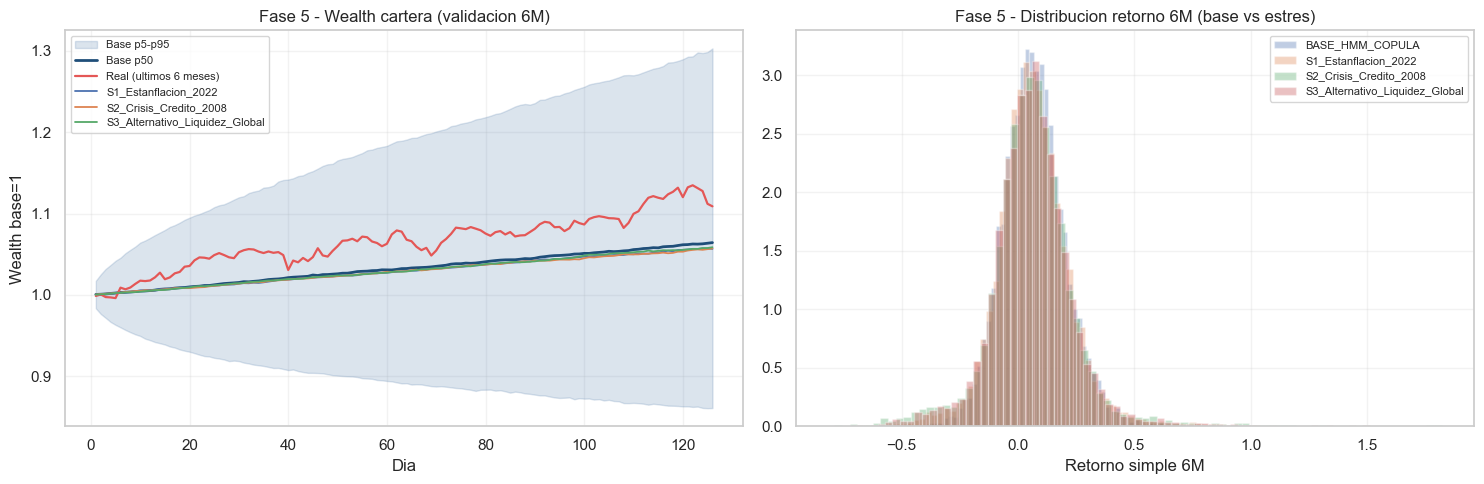

,scenario,label,dependence_shock,tail_shock,vol_shock,drift_shock,df_used,vol_mult,tail_mult,mean_shift,apply_to,avg_corr_risky,avg_corr_bonds_hedge,avg_corr_hyg_equity,desc,delta_avg_corr_risky,delta_avg_corr_bonds_hedge,delta_avg_corr_hyg_equity
0,BASE_HMM_COPULA,Base (HMM + copulas por estado),No,No,No,No,7.00,1.00,1.00,0.0000,all,0.484974,-0.161521,0.466364,Simulacion base sin shock adicional.,0.000000,0.000000,0.000000
1,S1_Estanflacion_2022,Escenario 1 (Estanflacion 2022),Si,Si,Si,Si,6.30,1.35,1.25,-0.0004,"AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG",0.604236,0.091544,0.594000,"Inflacion persistente: equity y bonos corrigen juntos, volatilidad elevada.",0.119262,0.253065,0.127636
2,S2_Crisis_Credito_2008,Escenario 2 (Crisis de Credito 2008),Si,Si,Si,Si,4.55,1.55,1.70,-0.0008,"HYG,AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM",0.802919,-0.161521,0.838318,"Ruptura de credito: HYG y equity altamente sincronizados, cola izquierda severa.",0.317945,0.000000,0.371954
3,S3_Alternativo_Liquidez_Global,Escenario 3 (Alternativo: Contagio de liquidez),Si,Si,Si,Si,5.60,1.45,1.45,-0.0006,"AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG",0.685990,-0.161521,0.678545,Shock de liquidez transversal con aumento de correlaciones y colas en todos los bloques.,0.201016,0.000000,0.212182


Saved phase5 outputs in C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller


In [19]:
# --- Phase 5: stress scenarios (10k paths, 6-month horizon) ---

N_STRESS=10_000
HORIZON_STRESS_DAYS=126
SEED_STRESS=123
EXPORT_STRESS=True
ALPHA_99=0.01

required=['assets','w','P','pi','params_by_state','hist_by_state','_simulate_states','_sample_state','_var_es','_mdd_logret','_nearest_psd_corr']
missing=[k for k in required if k not in globals()]
if missing: raise RuntimeError(f'Missing prereqs for Phase 5: {missing}. Run Phase 4 first.')

OUT_DIR=Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('outputs_taller')
OUT_DIR.mkdir(parents=True,exist_ok=True)
ret=returns.copy(); assets=list(assets); w=np.asarray(w,float)

base_df=float(params_by_state['Estres']['df'])
base_Ct=np.asarray(params_by_state['Estres']['Ct'],float)
histS=hist_by_state['Estres'].copy()

def _sample_t_copula_u(n,C,df,rng):
    d=C.shape[0]; C=_nearest_psd_corr(C); L=np.linalg.cholesky(C)
    y=rng.standard_normal((n,d))@L.T; wchi=rng.chisquare(df,size=n)/df; z=y/np.sqrt(wchi)[:,None]
    from scipy.stats import t as _t
    u=_t.cdf(z,df=df); return np.clip(u,1e-6,1-1e-6)

def _inv_empirical(u,sample):
    x=np.asarray(sample,float); x=x[np.isfinite(x)]
    if len(x)<20: return np.full_like(u,np.nan,float)
    xs=np.sort(x); p=np.arange(1,len(xs)+1)/(len(xs)+1.0)
    return np.interp(u,p,xs)

def _simulate_state_from_copula(n,Ct,df,hist,rng):
    hist=hist.loc[:,assets].dropna(how='any')
    U=_sample_t_copula_u(n,Ct,df,rng); R=np.zeros((n,len(assets)),float)
    for j,a in enumerate(assets): R[:,j]=_inv_empirical(U[:,j],hist[a].to_numpy())
    return R

def _shock_dependence_contagion(C,risky_idx,target_rho=0.85,alpha=0.60):
    C2=np.array(C,float,copy=True)
    for i in risky_idx:
        for j in risky_idx:
            if i!=j: C2[i,j]=(1-alpha)*C2[i,j]+alpha*target_rho
    np.fill_diagonal(C2,1.0); return _nearest_psd_corr(C2)

def _tweak_pairs(C,pairs,alpha=0.70):
    C2=np.array(C,float,copy=True)
    for a,b,target in pairs:
        if a in assets and b in assets:
            i,j=assets.index(a),assets.index(b)
            C2[i,j]=(1-alpha)*C2[i,j]+alpha*float(target); C2[j,i]=C2[i,j]
    np.fill_diagonal(C2,1.0); return _nearest_psd_corr(C2)

def _shock_marginal_vol_mean(R,vol_mult=1.50,mean_shift=0.0,cols=None):
    X=np.array(R,float,copy=True)
    if cols is None: cols=list(range(X.shape[1]))
    mu=np.nanmean(X[:,cols],axis=0); X[:,cols]=(mu+vol_mult*(X[:,cols]-mu))+float(mean_shift)
    return X

def _shock_tail_left(R,q=0.01,tail_mult=1.50,cols=None):
    X=np.array(R,float,copy=True)
    if cols is None: cols=list(range(X.shape[1]))
    for j in cols:
        qv=float(np.quantile(X[:,j],q)); m=X[:,j]<=qv; X[m,j]=qv+float(tail_mult)*(X[m,j]-qv)
    return X

def _portfolio_metrics(R,w):
    rp=R@w; v5,e5=_var_es(rp,0.05); v1,e1=_var_es(rp,0.01)
    return {'VaR5':float(v5),'ES5':float(e5),'VaR1':float(v1),'ES1':float(e1),'mean':float(np.mean(rp)),'vol':float(np.std(rp,ddof=1))}

def _portfolio_metrics_paths(rp_paths):
    daily=rp_paths.reshape(-1); sixm=np.exp(np.sum(rp_paths,axis=1))-1.0
    mdd=np.array([_mdd_logret(rp_paths[i]) for i in range(rp_paths.shape[0])],float)
    v99d,e99d=_var_es(daily,ALPHA_99); v99m,e99m=_var_es(sixm,ALPHA_99)
    return {'vol_daily':float(np.std(daily,ddof=1)),'vol_ann':float(np.std(daily,ddof=1)*np.sqrt(252)),'max_drawdown_mean':float(np.mean(mdd)),'max_drawdown_p95':float(np.quantile(mdd,0.95)),'VaR99_daily':float(v99d),'ES99_daily':float(e99d),'VaR99_6m':float(v99m),'ES99_6m':float(e99m)}

if 'EQUITY_TICKERS' in globals() and EQUITY_TICKERS: EQUITY_CORE=[t for t in EQUITY_TICKERS if t in assets]
else: EQUITY_CORE=[t for t in assets if t not in ['GLD','IEF','SHY','HYG']]
RISKY=[t for t in (EQUITY_CORE+['HYG']) if t in assets]; risky_idx=[assets.index(a) for a in RISKY]

scenario_specs=[
{'name':'S1_Estanflacion_2022','label':'Escenario 1 (Estanflacion 2022)','desc':'Inflacion persistente: equity y bonos corrigen juntos, volatilidad elevada.','df':max(3.0,base_df*0.90),'Ct':np.array(base_Ct,copy=True),'vol_mult':1.35,'tail_mult':1.25,'mean_shift':-0.0004,'apply_cols':list(range(len(assets)))},
{'name':'S2_Crisis_Credito_2008','label':'Escenario 2 (Crisis de Credito 2008)','desc':'Ruptura de credito: HYG y equity altamente sincronizados, cola izquierda severa.','df':max(3.0,base_df*0.65),'Ct':np.array(base_Ct,copy=True),'vol_mult':1.55,'tail_mult':1.70,'mean_shift':-0.0008,'apply_cols':[assets.index('HYG')]+[assets.index(x) for x in EQUITY_CORE if x in assets] if 'HYG' in assets else list(range(len(assets)))},
{'name':'S3_Alternativo_Liquidez_Global','label':'Escenario 3 (Alternativo: Contagio de liquidez)','desc':'Shock de liquidez transversal con aumento de correlaciones y colas en todos los bloques.','df':max(3.0,base_df*0.80),'Ct':np.array(base_Ct,copy=True),'vol_mult':1.45,'tail_mult':1.45,'mean_shift':-0.0006,'apply_cols':list(range(len(assets)))}]

pairs_eq_bond=[]
for eq in EQUITY_CORE:
    if 'IEF' in assets: pairs_eq_bond.append((eq,'IEF',0.25))
    if 'SHY' in assets: pairs_eq_bond.append((eq,'SHY',0.15))
pairs_hyg_eq=[('HYG',eq,0.85) for eq in EQUITY_CORE] if 'HYG' in assets else []
pairs_liq=[(a,'GLD',0.25) for a in RISKY if 'GLD' in assets]

for spec in scenario_specs:
    if spec['name']=='S1_Estanflacion_2022':
        C1=_shock_dependence_contagion(base_Ct,risky_idx,target_rho=0.75,alpha=0.45); spec['Ct']=_tweak_pairs(C1,pairs_eq_bond,alpha=0.70)
    elif spec['name']=='S2_Crisis_Credito_2008':
        C2=_shock_dependence_contagion(base_Ct,risky_idx,target_rho=0.90,alpha=0.75); spec['Ct']=_tweak_pairs(C2,pairs_hyg_eq,alpha=0.80)
    else:
        C3=_shock_dependence_contagion(base_Ct,risky_idx,target_rho=0.82,alpha=0.60); spec['Ct']=_tweak_pairs(C3,pairs_liq,alpha=0.55)

def _simulate_paths_under_spec(spec,n_paths,horizon,seed):
    rng=np.random.default_rng(seed); S=_simulate_states(n_paths,horizon,P,pi,rng); sf=S.reshape(-1)
    idxN=np.flatnonzero(sf==0); idxS=np.flatnonzero(sf==1); Rf=np.zeros((sf.size,len(assets)),float)
    Rf[idxN]=_sample_state(len(idxN),params_by_state['Normal']['Ct'],params_by_state['Normal']['df'],hist_by_state['Normal'],rng)
    Rs=_sample_state(len(idxS),spec['Ct'],spec['df'],hist_by_state['Estres'],rng)
    Rs=_shock_marginal_vol_mean(Rs,vol_mult=float(spec['vol_mult']),mean_shift=float(spec.get('mean_shift',0.0)),cols=spec.get('apply_cols'))
    Rs=_shock_tail_left(Rs,q=0.01,tail_mult=float(spec['tail_mult']),cols=spec.get('apply_cols'))
    Rf[idxS]=Rs
    Rp=Rf.reshape(n_paths,horizon,len(assets)); rpp=np.einsum('ntd,d->nt',Rp,w); W=np.exp(np.cumsum(rpp,axis=1))
    return {'S_paths':S,'R_paths':Rp,'rp_paths':rpp,'wealth_paths':W,'R_flat':Rf}

base_spec={'name':'BASE_HMM_COPULA','label':'Base (HMM + copulas por estado)','desc':'Simulacion base sin shock adicional.','df':base_df,'Ct':np.array(base_Ct,copy=True),'vol_mult':1.0,'tail_mult':1.0,'mean_shift':0.0,'apply_cols':None}
all_specs=[base_spec]+scenario_specs
scenario_results={}; rows=[]

for i,spec in enumerate(all_specs):
    out=_simulate_paths_under_spec(spec,N_STRESS,HORIZON_STRESS_DAYS,SEED_STRESS+i); scenario_results[spec['name']]=out
    m=_portfolio_metrics_paths(out['rp_paths'])
    reg=np.array([_state_stats(out['S_paths'][k])['pct_estres'] for k in range(out['S_paths'].shape[0])],float)
    dur=np.array([_state_stats(out['S_paths'][k])['avg_dur_estres'] for k in range(out['S_paths'].shape[0])],float)
    sw=np.array([_state_stats(out['S_paths'][k])['n_switches'] for k in range(out['S_paths'].shape[0])],float)
    sf=out['S_paths'].reshape(-1); idxS=np.flatnonzero(sf==1); stress_df=pd.DataFrame(out['R_flat'][idxS],columns=assets)
    C=stress_df.corr().to_numpy(float); iu=np.triu_indices(C.shape[0],k=1); v=C[iu]; v=v[np.isfinite(v)]; avg_corr=float(np.mean(v)) if len(v) else np.nan
    rows.append({'scenario':spec['name'],'label':spec.get('label',spec['name']),'desc':spec['desc'],'n_paths':int(N_STRESS),'horizon_days':int(HORIZON_STRESS_DAYS),'df_used_stress':float(spec['df']),'vol_mult_stress':float(spec['vol_mult']),'tail_mult_stress':float(spec['tail_mult']),'mean_shift_stress':float(spec.get('mean_shift',0.0)),'pct_estres_sim':float(np.nanmean(reg)),'avg_dur_estres_sim':float(np.nanmean(dur)),'n_switches_sim':float(np.nanmean(sw)),'avg_corr_stress_sim':float(avg_corr),**m})

stress_summary=pd.DataFrame(rows).sort_values('ES99_6m').reset_index(drop=True)
display(stress_summary)

rp_real=(ret[assets]@w).dropna(); rp_real_last=rp_real.iloc[-HORIZON_STRESS_DAYS:].to_numpy(); wealth_real_last=np.exp(np.cumsum(rp_real_last))
days=np.arange(1,HORIZON_STRESS_DAYS+1)
fig,axes=plt.subplots(1,2,figsize=(15,5))
base_w=scenario_results['BASE_HMM_COPULA']['wealth_paths']; p5=np.percentile(base_w,5,axis=0); p50=np.percentile(base_w,50,axis=0); p95=np.percentile(base_w,95,axis=0)
axes[0].fill_between(days,p5,p95,alpha=0.20,color='#4C78A8',label='Base p5-p95'); axes[0].plot(days,p50,color='#1f4e79',lw=2.0,label='Base p50'); axes[0].plot(days,wealth_real_last,color='#E45756',lw=1.6,label='Real (ultimos 6 meses)')
for spec in scenario_specs:
    med=np.percentile(scenario_results[spec['name']]['wealth_paths'],50,axis=0); axes[0].plot(days,med,lw=1.3,label=spec['name'])
axes[0].set_title('Fase 5 - Wealth cartera (validacion 6M)'); axes[0].set_xlabel('Dia'); axes[0].set_ylabel('Wealth base=1'); axes[0].grid(alpha=0.25); axes[0].legend(fontsize=8)
for spec in all_specs:
    sixm=np.exp(np.sum(scenario_results[spec['name']]['rp_paths'],axis=1))-1.0; axes[1].hist(sixm,bins=80,density=True,alpha=0.35,label=spec['name'])
axes[1].set_title('Fase 5 - Distribucion retorno 6M (base vs estres)'); axes[1].set_xlabel('Retorno simple 6M'); axes[1].grid(alpha=0.25); axes[1].legend(fontsize=8)
plt.tight_layout(); plt.show()


def _avg_block_corr(C,names):
    idx=[assets.index(a) for a in names if a in assets]
    if len(idx)<2: return np.nan
    vals=[]
    for i in range(len(idx)):
        for j in range(i+1,len(idx)): vals.append(float(C[idx[i],idx[j]]))
    return float(np.mean(vals)) if vals else np.nan

def _avg_pair_corr(C,pairs):
    vals=[]
    for a,b in pairs:
        if a in assets and b in assets:
            i,j=assets.index(a),assets.index(b); vals.append(float(C[i,j]))
    return float(np.mean(vals)) if vals else np.nan

pairs_bonds=[]
for eq in EQUITY_CORE:
    for b in ['IEF','SHY']:
        if b in assets: pairs_bonds.append((eq,b))
pairs_hyg=[('HYG',eq) for eq in EQUITY_CORE] if 'HYG' in assets else []

lever_rows=[]
for spec in all_specs:
    Ct=np.asarray(spec['Ct'],float); ac=spec.get('apply_cols')
    apply_to=','.join([assets[i] for i in ac if 0<=i<len(assets)]) if isinstance(ac,list) else 'all'
    lever_rows.append({'scenario':spec['name'],'label':spec.get('label',spec['name']),'dependence_shock':'No' if spec['name']=='BASE_HMM_COPULA' else 'Si','tail_shock':'Si' if float(spec.get('tail_mult',1.0))>1.0 or float(spec.get('df',base_df))<float(base_df) else 'No','vol_shock':'Si' if float(spec.get('vol_mult',1.0))>1.0 else 'No','drift_shock':'Si' if abs(float(spec.get('mean_shift',0.0)))>0 else 'No','df_used':float(spec['df']),'vol_mult':float(spec['vol_mult']),'tail_mult':float(spec['tail_mult']),'mean_shift':float(spec.get('mean_shift',0.0)),'apply_to':apply_to,'avg_corr_risky':_avg_block_corr(Ct,RISKY),'avg_corr_bonds_hedge':_avg_pair_corr(Ct,pairs_bonds),'avg_corr_hyg_equity':_avg_pair_corr(Ct,pairs_hyg),'desc':spec['desc']})

lever_tbl=pd.DataFrame(lever_rows)
base_row=lever_tbl[lever_tbl['scenario']=='BASE_HMM_COPULA'].iloc[0]
lever_tbl['delta_avg_corr_risky']=lever_tbl['avg_corr_risky']-float(base_row['avg_corr_risky'])
lever_tbl['delta_avg_corr_bonds_hedge']=lever_tbl['avg_corr_bonds_hedge']-float(base_row['avg_corr_bonds_hedge'])
lever_tbl['delta_avg_corr_hyg_equity']=lever_tbl['avg_corr_hyg_equity']-float(base_row['avg_corr_hyg_equity'])
display(lever_tbl)

if EXPORT_STRESS:
    stress_summary.to_csv(OUT_DIR/f'phase5_stress_summary_6m_n{N_STRESS}.csv',index=False)
    lever_tbl.to_csv(OUT_DIR/f'phase5_stress_levers_summary_6m_n{N_STRESS}.csv',index=False)
    lever_tbl.to_csv(OUT_DIR/'phase5_stress_levers_summary.csv',index=False)
    print('Saved phase5 outputs in',OUT_DIR)


In [20]:
# --- Phase 5 (reporting): levers / palancas summary ---

OUT_DIR=Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('outputs_taller')
if 'lever_tbl' not in globals() or lever_tbl is None:
    p1=OUT_DIR/f'phase5_stress_levers_summary_6m_n{N_STRESS}.csv'
    p2=OUT_DIR/'phase5_stress_levers_summary.csv'
    if p1.exists(): lever_tbl=pd.read_csv(p1)
    elif p2.exists(): lever_tbl=pd.read_csv(p2)
    else: raise RuntimeError('No encuentro tabla de palancas. Ejecuta primero la celda principal de Fase 5.')

cols=['scenario','label','dependence_shock','tail_shock','vol_shock','drift_shock','df_used','vol_mult','tail_mult','mean_shift','apply_to','avg_corr_risky','avg_corr_bonds_hedge','avg_corr_hyg_equity','delta_avg_corr_risky','delta_avg_corr_bonds_hedge','delta_avg_corr_hyg_equity','desc']
lever_tbl=lever_tbl[[c for c in cols if c in lever_tbl.columns]]
display(lever_tbl)
lever_tbl.to_csv(OUT_DIR/f'phase5_stress_levers_summary_6m_n{N_STRESS}.csv',index=False)
print('Saved:',OUT_DIR/f'phase5_stress_levers_summary_6m_n{N_STRESS}.csv')


,scenario,label,dependence_shock,tail_shock,vol_shock,drift_shock,df_used,vol_mult,tail_mult,mean_shift,apply_to,avg_corr_risky,avg_corr_bonds_hedge,avg_corr_hyg_equity,delta_avg_corr_risky,delta_avg_corr_bonds_hedge,delta_avg_corr_hyg_equity,desc
0,BASE_HMM_COPULA,Base (HMM + copulas por estado),No,No,No,No,7.00,1.00,1.00,0.0000,all,0.484974,-0.161521,0.466364,0.000000,0.000000,0.000000,Simulacion base sin shock adicional.
1,S1_Estanflacion_2022,Escenario 1 (Estanflacion 2022),Si,Si,Si,Si,6.30,1.35,1.25,-0.0004,"AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG",0.604236,0.091544,0.594000,0.119262,0.253065,0.127636,"Inflacion persistente: equity y bonos corrigen juntos, volatilidad elevada."
2,S2_Crisis_Credito_2008,Escenario 2 (Crisis de Credito 2008),Si,Si,Si,Si,4.55,1.55,1.70,-0.0008,"HYG,AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM",0.802919,-0.161521,0.838318,0.317945,0.000000,0.371954,"Ruptura de credito: HYG y equity altamente sincronizados, cola izquierda severa."
3,S3_Alternativo_Liquidez_Global,Escenario 3 (Alternativo: Contagio de liquidez),Si,Si,Si,Si,5.60,1.45,1.45,-0.0006,"AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG",0.685990,-0.161521,0.678545,0.201016,0.000000,0.212182,Shock de liquidez transversal con aumento de correlaciones y colas en todos los bloques.


Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase5_stress_levers_summary_6m_n10000.csv


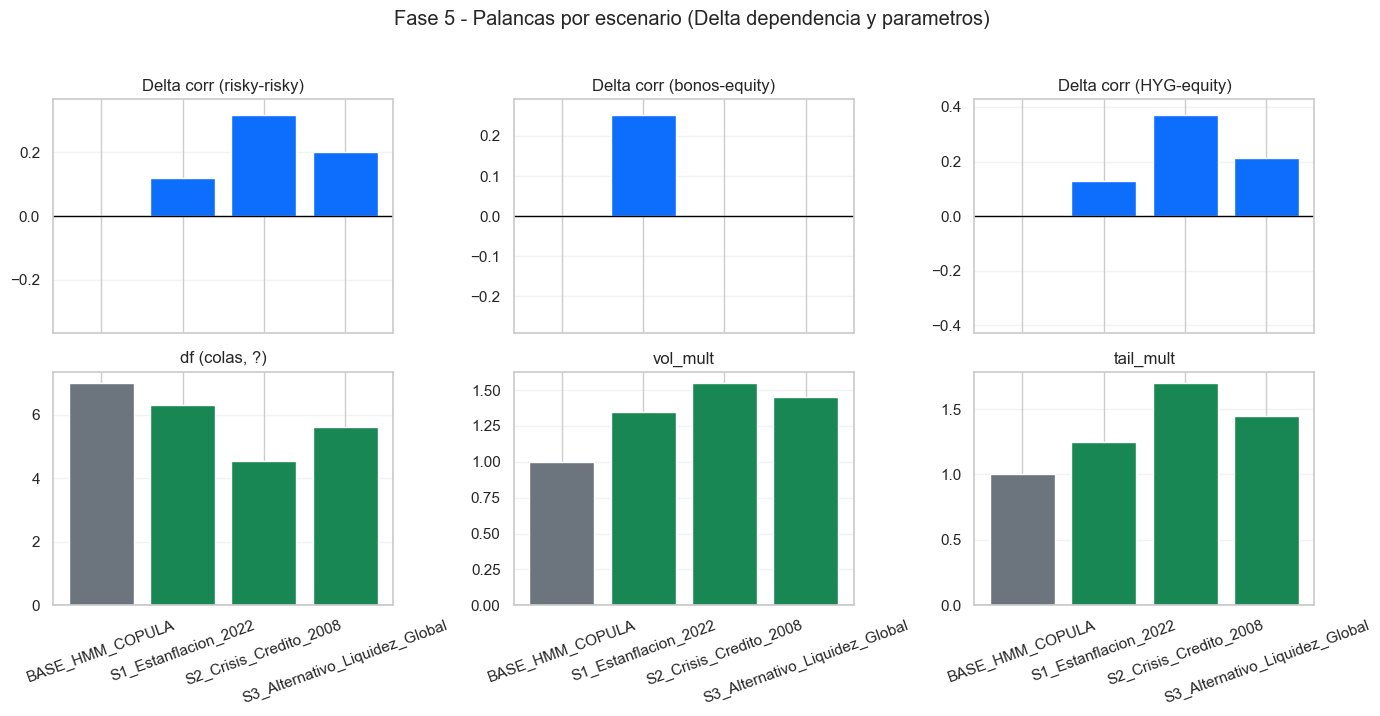

Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase5_levers_barplot_6m_n10000.png


In [21]:
# --- Phase 5 - Plots de palancas (comite-friendly) ---

OUT_DIR=Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('outputs_taller')
_lever_tbl=globals().get('lever_tbl')
if _lever_tbl is None:
    p=OUT_DIR/f'phase5_stress_levers_summary_6m_n{N_STRESS}.csv'
    if not p.exists(): raise RuntimeError('No encuentro tabla de palancas. Ejecuta la celda anterior de Fase 5.')
    _lever_tbl=pd.read_csv(p)

if 'scenario' in _lever_tbl.columns:
    order=['BASE_HMM_COPULA','S1_Estanflacion_2022','S2_Crisis_Credito_2008','S3_Alternativo_Liquidez_Global']
    cats=[c for c in order if c in set(_lever_tbl['scenario'])]
    _lever_tbl=_lever_tbl.copy(); _lever_tbl['scenario']=pd.Categorical(_lever_tbl['scenario'],categories=cats,ordered=True); _lever_tbl=_lever_tbl.sort_values('scenario')

x=_lever_tbl['scenario'].astype(str).tolist() if 'scenario' in _lever_tbl.columns else [str(i) for i in range(len(_lever_tbl))]
fig,axes=plt.subplots(2,3,figsize=(14,7),sharex=True)
cm={'Delta corr (risky-risky)':'delta_avg_corr_risky','Delta corr (bonos-equity)':'delta_avg_corr_bonds_hedge','Delta corr (HYG-equity)':'delta_avg_corr_hyg_equity'}
pm={'df (colas, ?)':'df_used','vol_mult':'vol_mult','tail_mult':'tail_mult'}
for ax,(ttl,col) in zip(axes[0],cm.items()):
    if col in _lever_tbl.columns:
        y=pd.to_numeric(_lever_tbl[col],errors='coerce').to_numpy(); ax.bar(x,y,color=['#6c757d' if 'BASE' in s else '#0d6efd' for s in x]); lim=max(0.02,float(np.nanmax(np.abs(y)))*1.15) if np.isfinite(y).any() else 0.05; ax.axhline(0,color='black',lw=1); ax.set_ylim(-lim,lim)
    else: ax.text(0.5,0.5,f'Falta columna: {col}',ha='center',va='center')
    ax.set_title(ttl); ax.grid(True,axis='y',alpha=0.25)
for ax,(ttl,col) in zip(axes[1],pm.items()):
    if col in _lever_tbl.columns:
        y=pd.to_numeric(_lever_tbl[col],errors='coerce').to_numpy(); ax.bar(x,y,color=['#6c757d' if 'BASE' in s else '#198754' for s in x]); ax.axhline(0,color='black',lw=1)
    else: ax.text(0.5,0.5,f'Falta columna: {col}',ha='center',va='center')
    ax.set_title(ttl); ax.grid(True,axis='y',alpha=0.25)
for ax in axes[1]: ax.tick_params(axis='x',rotation=20)
fig.suptitle('Fase 5 - Palancas por escenario (Delta dependencia y parametros)', y=1.02)
plt.tight_layout(); plt.show()
if globals().get('EXPORT_STRESS',False):
    out=OUT_DIR/f'phase5_levers_barplot_6m_n{N_STRESS}.png'; fig.savefig(out,dpi=160,bbox_inches='tight'); print('Saved:',out)


## 6) Fase 6 - Reverse stress testing

Pregunta de gestion: cual es el shock mínimo para cruzar un umbral de pérdida inaceptable.

Enfoque aplicado:

- baseline en régimen Estrés,
- interpolación de intensidad `lambda in [0,1]` sobre familias de shocks,
- búsqueda del `lambda` mínimo que rompe el umbral objetivo.

Outputs: grid completo, mínimo por familia, mejor global y análisis de sensibilidad.


Baseline ES5 (Estres model): -4.2290%
Target   ES5: -6.7665%  (TARGET_MULT=1.6, TARGET_ABS=None)


,target_mult,target_value,family,min_lambda,metric_at_min,status
0,1.4,-0.059206,S1_Estanflacion_2022,0.70,-0.060193,CROSS
1,1.4,-0.059206,S2_Crisis_Credito_2008,0.35,-0.060626,CROSS
2,1.4,-0.059206,S3_Alternativo_Liquidez_Global,0.45,-0.059512,CROSS
3,1.6,-0.067665,S1_Estanflacion_2022,0.95,-0.068168,CROSS
4,1.6,-0.067665,S2_Crisis_Credito_2008,0.50,-0.070634,CROSS
5,1.6,-0.067665,S3_Alternativo_Liquidez_Global,0.65,-0.068133,CROSS
6,1.8,-0.076123,S1_Estanflacion_2022,NaN,NaN,NO_CROSS
7,1.8,-0.076123,S2_Crisis_Credito_2008,0.65,-0.079522,CROSS
8,1.8,-0.076123,S3_Alternativo_Liquidez_Global,0.85,-0.078514,CROSS


Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase6_reverse_stress_sensitivity_1d_n25000.csv
Best reverse-stress (min λ): S2_Crisis_Credito_2008 @ λ=0.50


,family,lambda_min,status,ES5,ES5,VaR5,ES1,VaR1,df_used,vol_mult,tail_mult,apply_to
0,S1_Estanflacion_2022,0.95,CROSS,-0.068168,-0.068168,-0.043233,-0.111120,-0.082364,6.335,1.3325,1.2375,"AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG"
1,S2_Crisis_Credito_2008,0.50,CROSS,-0.070634,-0.070634,-0.042697,-0.120155,-0.088693,5.775,1.2750,1.3500,"HYG,AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM"
2,S3_Alternativo_Liquidez_Global,0.65,CROSS,-0.068133,-0.068133,-0.042571,-0.112306,-0.082346,6.090,1.2925,1.2925,"AAPL,AMZN,BAC,BRK-B,CVX,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG"


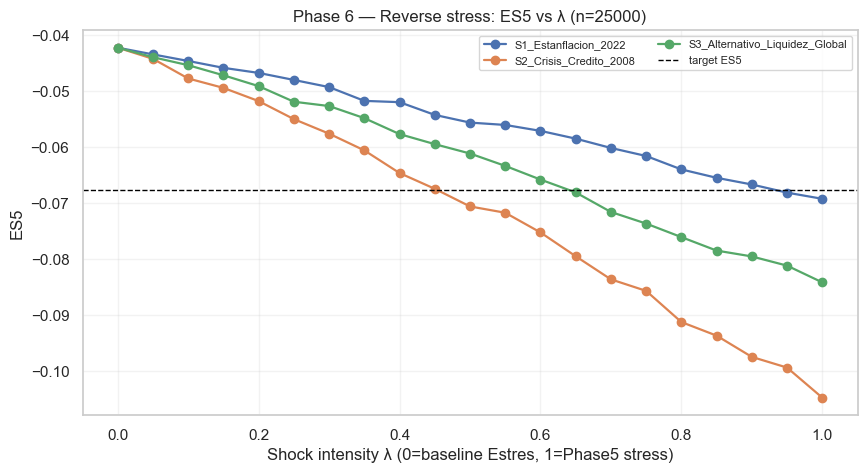

Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase6_reverse_stress_grid_1d_n25000.csv
Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase6_reverse_stress_minimum_1d_n25000.csv
Saved: C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase6_reverse_stress_plot_1d_n25000.png


In [22]:
# --- Phase 6: Reverse stress testing (minimum shock intensity λ) ---

# Settings
N_REV = 25_000
SEED_REV = 777
EXPORT_REV = True

# Metric and threshold
TARGET_METRIC = "ES5"   # {"ES5","VaR5","ES1","VaR1"}
TARGET_MULT = 1.60      # threshold = baseline_metric * TARGET_MULT (more negative)
TARGET_ABS = None       # e.g. -0.04 (overrides TARGET_MULT if not None)

# Sensitivity multipliers for justification (uses same grid)
SENSITIVITY_MULTS = [1.4, 1.6, 1.8]

# Preconditions
required = ["assets", "histS", "base_Ct", "base_df", "scenario_specs", "w"]
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Missing prereqs for Phase 6: {missing}. Run Phase 5 first.")

OUT_DIR = Path(OUT_DIR) if "OUT_DIR" in globals() else Path("outputs_taller")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Reuse helpers from Phase 5, fallback if needed
if "_nearest_psd_corr" not in globals():
    raise RuntimeError("Missing _nearest_psd_corr. Run Phase 5 cell first.")
if "_simulate_state_from_copula" not in globals():
    raise RuntimeError("Missing _simulate_state_from_copula. Run Phase 5 cell first.")
if "_shock_marginal_vol_mean" not in globals() or "_shock_tail_left" not in globals():
    raise RuntimeError("Missing marginal shock helpers. Run Phase 5 cell first.")
if "_portfolio_metrics" not in globals():
    raise RuntimeError("Missing _portfolio_metrics. Run Phase 5 cell first.")


def _blend_corr(C0: np.ndarray, C1: np.ndarray, lam: float) -> np.ndarray:
    lam = float(np.clip(lam, 0.0, 1.0))
    C = (1.0 - lam) * np.asarray(C0, dtype=float) + lam * np.asarray(C1, dtype=float)
    np.fill_diagonal(C, 1.0)
    return _nearest_psd_corr(C)


def _lin(a: float, b: float, lam: float) -> float:
    lam = float(np.clip(lam, 0.0, 1.0))
    return float((1.0 - lam) * a + lam * b)


def _eval_lambda(spec: dict, lam: float, n: int, seed: int) -> dict:
    Ct_l = _blend_corr(base_Ct, np.asarray(spec["Ct"], dtype=float), lam)
    df_l = _lin(float(base_df), float(spec["df"]), lam)
    vol_mult_l = _lin(1.0, float(spec["vol_mult"]), lam)
    tail_mult_l = _lin(1.0, float(spec["tail_mult"]), lam)

    rng = np.random.default_rng(seed)
    R = _simulate_state_from_copula(n, Ct_l, df_l, histS, rng)

    cols = spec.get("apply_cols")
    R = _shock_marginal_vol_mean(R, vol_mult=vol_mult_l, mean_shift=0.0, cols=cols)
    R = _shock_tail_left(R, q=0.05, tail_mult=tail_mult_l, cols=cols)

    m = _portfolio_metrics(R, w)

    # Add levers for reporting
    apply_cols = spec.get("apply_cols")
    if isinstance(apply_cols, list):
        apply_names = [assets[i] for i in apply_cols if 0 <= i < len(assets)]
        apply_to = ",".join(apply_names) if apply_names else "(subset)"
    else:
        apply_to = "all"

    return {
        "family": spec["name"],
        "lambda": float(lam),
        "n": int(n),
        "seed": int(seed),
        "df_used": float(df_l),
        "vol_mult": float(vol_mult_l),
        "tail_mult": float(tail_mult_l),
        "apply_to": apply_to,
        **m,
    }


# Baseline metric under Estres model (λ=0)
if "R_base" in globals() and isinstance(globals().get("R_base"), np.ndarray):
    base_metrics = _portfolio_metrics(R_base, w)
else:
    rng0 = np.random.default_rng(SEED_REV)
    R0 = _simulate_state_from_copula(N_REV, base_Ct, float(base_df), histS, rng0)
    base_metrics = _portfolio_metrics(R0, w)

baseline_value = float(base_metrics.get(TARGET_METRIC, np.nan))
if not np.isfinite(baseline_value):
    raise RuntimeError(f"Baseline metric {TARGET_METRIC} is NaN; cannot reverse-stress.")

if TARGET_ABS is not None:
    target_value = float(TARGET_ABS)
else:
    target_value = float(baseline_value * TARGET_MULT)

print(f"Baseline {TARGET_METRIC} (Estres model): {baseline_value:.4%}")
print(f"Target   {TARGET_METRIC}: {target_value:.4%}  (TARGET_MULT={TARGET_MULT}, TARGET_ABS={TARGET_ABS})")


# Grid search over λ for each Phase-5 family
lams = np.linspace(0.0, 1.0, 21)
rows = []

for spec in scenario_specs:
    for lam in lams:
        rows.append(_eval_lambda(spec, float(lam), n=N_REV, seed=SEED_REV))

grid = pd.DataFrame(rows)

# Find minimal λ that crosses the target (for loss metrics, more negative is "worse")
# We assume VaR/ES are negative in returns space.
def _crosses(val: float, target: float) -> bool:
    return float(val) <= float(target)

# Sensitivity on threshold (no extra simulations, reuses grid)
if TARGET_ABS is None:
    sens_rows = []
    for mult in SENSITIVITY_MULTS:
        target_val = float(baseline_value * mult)
        for fam, g in grid.groupby("family", sort=False):
            g = g.sort_values("lambda")
            metric_series = g[TARGET_METRIC]
            idx = None
            for i in range(len(g)):
                v = float(metric_series.iloc[i])
                if np.isfinite(v) and _crosses(v, target_val):
                    idx = i
                    break
            sens_rows.append({
                "target_mult": mult,
                "target_value": target_val,
                "family": fam,
                "min_lambda": float(g.iloc[idx]["lambda"]) if idx is not None else np.nan,
                "metric_at_min": float(g.iloc[idx][TARGET_METRIC]) if idx is not None else np.nan,
                "status": "CROSS" if idx is not None else "NO_CROSS",
            })

    sens_tbl = pd.DataFrame(sens_rows)
    display(sens_tbl)
    if EXPORT_REV:
        out_sens = OUT_DIR / f"phase6_reverse_stress_sensitivity_1d_n{N_REV}.csv"
        sens_tbl.to_csv(out_sens, index=False)
        print("Saved:", out_sens)
else:
    print("[Info] TARGET_ABS set; sensitivity table uses TARGET_MULTs only when TARGET_ABS is None.")

min_rows = []
for fam, g in grid.groupby("family", sort=False):
    g = g.sort_values("lambda")
    metric_series = g[TARGET_METRIC]
    idx = None
    for i in range(len(g)):
        v = float(metric_series.iloc[i])
        if np.isfinite(v) and _crosses(v, target_value):
            idx = i
            break
    if idx is None:
        min_rows.append({"family": fam, "lambda_min": np.nan, "status": "NO_CROSS"})
        continue

    lam_hit = float(g["lambda"].iloc[idx])
    min_rows.append({
        "family": fam,
        "lambda_min": lam_hit,
        "status": "CROSS",
        TARGET_METRIC: float(g[TARGET_METRIC].iloc[idx]),
        "VaR5": float(g["VaR5"].iloc[idx]),
        "ES5": float(g["ES5"].iloc[idx]),
        "VaR1": float(g["VaR1"].iloc[idx]),
        "ES1": float(g["ES1"].iloc[idx]),
        "df_used": float(g["df_used"].iloc[idx]),
        "vol_mult": float(g["vol_mult"].iloc[idx]),
        "tail_mult": float(g["tail_mult"].iloc[idx]),
        "apply_to": str(g["apply_to"].iloc[idx]),
    })

min_tbl = pd.DataFrame(min_rows)

# Best (minimum λ across families)
best = min_tbl[min_tbl["status"] == "CROSS"].copy()
if len(best) > 0:
    best = best.sort_values(["lambda_min", TARGET_METRIC], ascending=[True, True]).head(1)
    best_family = str(best["family"].iloc[0])
    best_lambda = float(best["lambda_min"].iloc[0])
    print(f"Best reverse-stress (min λ): {best_family} @ λ={best_lambda:.2f}")
else:
    best_family, best_lambda = None, np.nan
    print("No family crossed the target on this λ-grid. Consider decreasing TARGET_MULT or setting TARGET_ABS closer to baseline.")

# Display
show_cols = ["family", "lambda_min", "status"]
extra = [c for c in [TARGET_METRIC, "ES5", "VaR5", "ES1", "VaR1", "df_used", "vol_mult", "tail_mult", "apply_to"] if c in min_tbl.columns]
show_cols = show_cols + [c for c in extra if c not in show_cols]

display(min_tbl[show_cols])


# Plot metric vs λ
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for fam, g in grid.groupby("family", sort=False):
    g = g.sort_values("lambda")
    ax.plot(g["lambda"], g[TARGET_METRIC], marker="o", lw=1.6, label=fam)

ax.axhline(target_value, color="black", ls="--", lw=1, label=f"target {TARGET_METRIC}")
ax.set_title(f"Phase 6 — Reverse stress: {TARGET_METRIC} vs λ (n={N_REV})")
ax.set_xlabel("Shock intensity λ (0=baseline Estres, 1=Phase5 stress)")
ax.set_ylabel(TARGET_METRIC)
ax.grid(True, alpha=0.25)
ax.legend(ncol=2, fontsize=8)
plt.show()


# Export
if EXPORT_REV:
    out_grid = OUT_DIR / f"phase6_reverse_stress_grid_1d_n{N_REV}.csv"
    grid.to_csv(out_grid, index=False)
    print("Saved:", out_grid)

    out_min = OUT_DIR / f"phase6_reverse_stress_minimum_1d_n{N_REV}.csv"
    min_tbl.to_csv(out_min, index=False)
    print("Saved:", out_min)

    if globals().get("EXPORT_STRESS", False):
        out_png = OUT_DIR / f"phase6_reverse_stress_plot_1d_n{N_REV}.png"
        fig.savefig(out_png, dpi=160, bbox_inches="tight")
        print("Saved:", out_png)


## 7) Conclusiones teécnicas

- El esquema de paneles (CORE/FULL/diagnóstico 2006) permite incluir el episodio 2008 sin imputaciones y mantener robustez del universo completo.
- La clasificación de regímenes separa períodos de calma y estrés con señales macro consistentes (volatilidad, drawdown y credito), incluyendo el bloque 2008-2009.
- En riesgo marginal, HYG muestra un salto fuerte de volatilidad en estrés (x2.70 vs normal), mientras que GLD no mantiene un perfil de refugio robusto en este corte.
- En dependencia, el estado de estrés presenta mas correlación media y mayor dependencia de cola que el estado normal, lo que confirma deterioro de diversificacion.
- El motor Monte Carlo replica bien magnitudes de riesgo base (volatilidad y cola diaria) y reproduce de forma coherente el peso relativo de cada régimen.
- En escenarios forzados, la Crisis de Crédito 2008 es el caso mas severo en VaR/ES 99% a 6 meses.
- En reverse stress, el umbral crítico se alcanza antes con el escenario de crédito, lo que lo posiciona como principal vulnerabilidad de la cartera.

## Control de entregables

La celda final verifica automaticamente que existan los outputs tecnicos clave generados por el notebook.

In [23]:
# --- Checklist tecnico de entregables ---

out = Path(OUT_DIR)
checks = [
    ("Fase 2: tabla riesgo por estado", out / "phase2_risk_by_state.csv"),
    ("Fase 3: copula summary", out / "phase3_copula_summary.json"),
    ("Fase 4: wealth bands 6m 10k", out / "phase4_wealth_bands_6m_n10000.csv"),
    ("Fase 4: reproduccion regimenes", out / "phase4_regime_reproduction_6m_n10000.csv"),
    ("Fase 4: validacion riesgo cartera", out / "phase4_portfolio_risk_validation_6m_n10000.csv"),
    ("Fase 4: validacion dependencia", out / "phase4_dependence_validation_6m_n10000.csv"),
    ("Fase 5: resumen escenarios estres", out / "phase5_stress_summary_6m_n10000.csv"),
    ("Fase 5: palancas escenarios", out / "phase5_stress_levers_summary_6m_n10000.csv"),
    ("Fase 6: reverse stress minimo", out / "phase6_reverse_stress_minimum_1d_n25000.csv"),
]

rows = []
for item, path in checks:
    rows.append({"item": item, "status": "OK" if path.exists() else "FALTA", "path": str(path)})

check_df = pd.DataFrame(rows)
display(check_df)

n_missing = int((check_df["status"] == "FALTA").sum())
if n_missing == 0:
    print("Checklist tecnico: completo.")
else:
    print(f"Checklist tecnico: faltan {n_missing} outputs.")

print("Control de entregables: se han verificado los archivos técnicos clave en outputs_taller/.")


,item,status,path
0,Fase 2: tabla riesgo por estado,OK,"C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase2_risk_by_state.csv"
1,Fase 3: copula summary,OK,"C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase3_copula_summary.json"
2,Fase 4: wealth bands 6m 10k,OK,"C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase4_wealth_bands_6m_n10000.csv"
3,Fase 4: reproduccion regimenes,OK,"C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase4_regime_reproduction_6m_n10000.csv"
4,Fase 4: validacion riesgo cartera,OK,"C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase4_portfolio_risk_validation_6m_n10000.csv"
5,Fase 4: validacion dependencia,OK,"C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase4_dependence_validation_6m_n10000.csv"
6,Fase 5: resumen escenarios estres,OK,"C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase5_stress_summary_6m_n10000.csv"
7,Fase 5: palancas escenarios,OK,"C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase5_stress_levers_summary_6m_n10000.csv"
8,Fase 6: reverse stress minimo,OK,"C:\Users\rvill\Desktop\MIAX\2 Introducción a los Sistemas Financieros\29, 30 y 31 enero. Gestión De Riesgos Financieros. Francisco Pérez Álvaro Arévalo-20260129\outputs_taller\phase6_reverse_stress_minimum_1d_n25000.csv"


Checklist tecnico: completo.
Control de entregables: se han verificado los archivos técnicos clave en outputs_taller/.
